<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

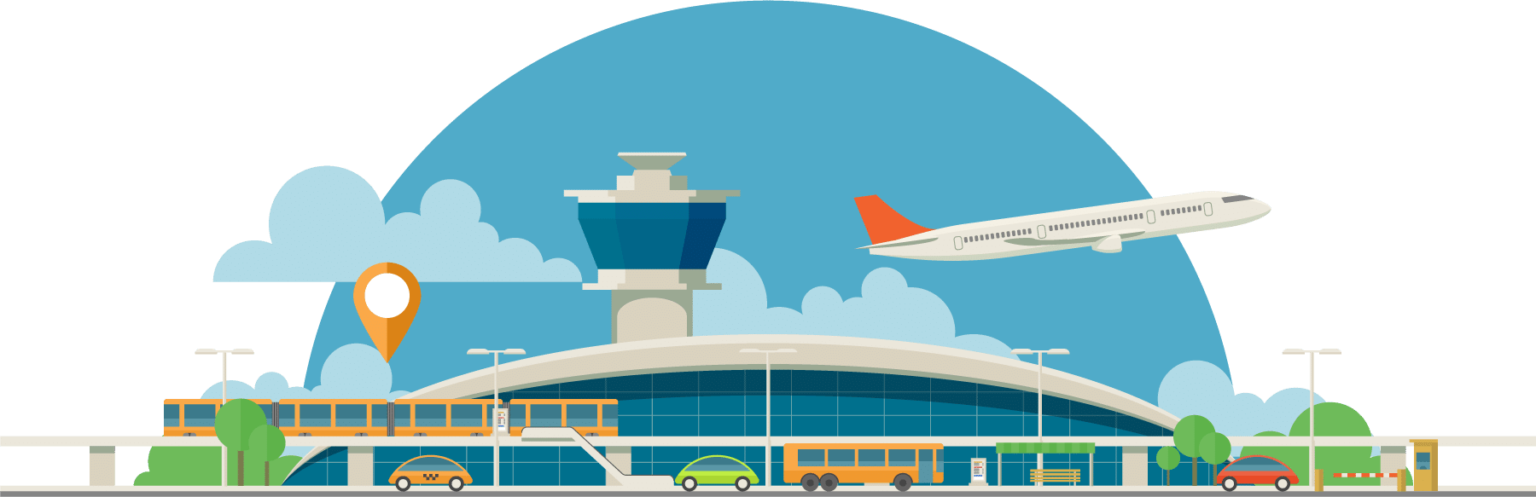

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost -q
!pip install mlxtend --upgrade -q
!pip install optuna -q
!pip install lime -q
!pip install shap -q
!pip install missingno -q
!pip install psycopg2-binary -q
!pip install dtreeviz -q

#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import dtreeviz
import shap
import lime
import lime.lime_tabular

import optuna

import pickle
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE=42
np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-23 12:45:25--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-23 12:45:26 (1.71 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [4]:
import psycopg2
from psycopg2 import Error
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

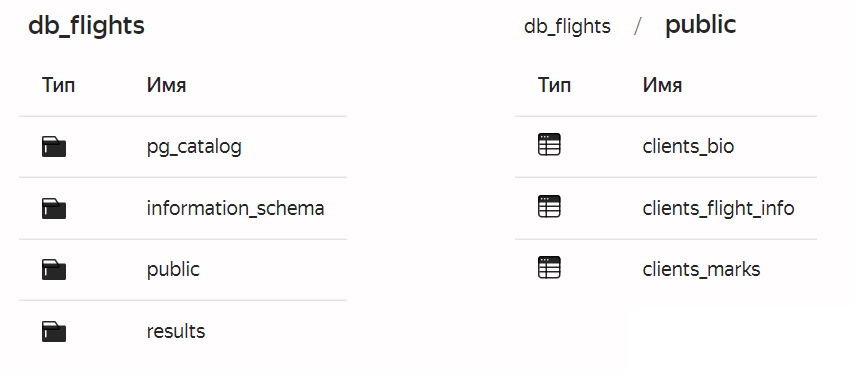



In [5]:
connection = psycopg2.connect(
    host="rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    port=6432,
    sslmode="verify-full",
    dbname="db_flights",
    user="mlhs_student",
    password="mlhs_student",
    target_session_attrs="read-write"
    )

In [6]:
sql = '''
SELECT *
FROM clients_bio
INNER JOIN clients_flight_info ON clients_bio.id = clients_flight_info.id
INNER JOIN clients_marks ON clients_bio.id = clients_marks.id;
'''

In [7]:
cursor = connection.cursor()
cursor.execute(sql)
result = cursor.fetchall()
cursor.close()

In [8]:
column_names = [desc[0] for desc in cursor.description]
data = pd.DataFrame(result, columns=column_names)
data = data.loc[:,~data.columns.duplicated()].copy()
data.set_index('id', inplace=True)

In [9]:
df = data.copy()
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [10]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [12]:
type(df['Flight Distance'][7])

str

In [13]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.nan if x == 'nan' else x)
    try:
        df[col] = df[col].astype(float)
    except ValueError:
        pass

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [15]:
df.isna().sum()

gender                                 0
age                                  315
Customer Type                         77
Type of Travel                       101
class                                116
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

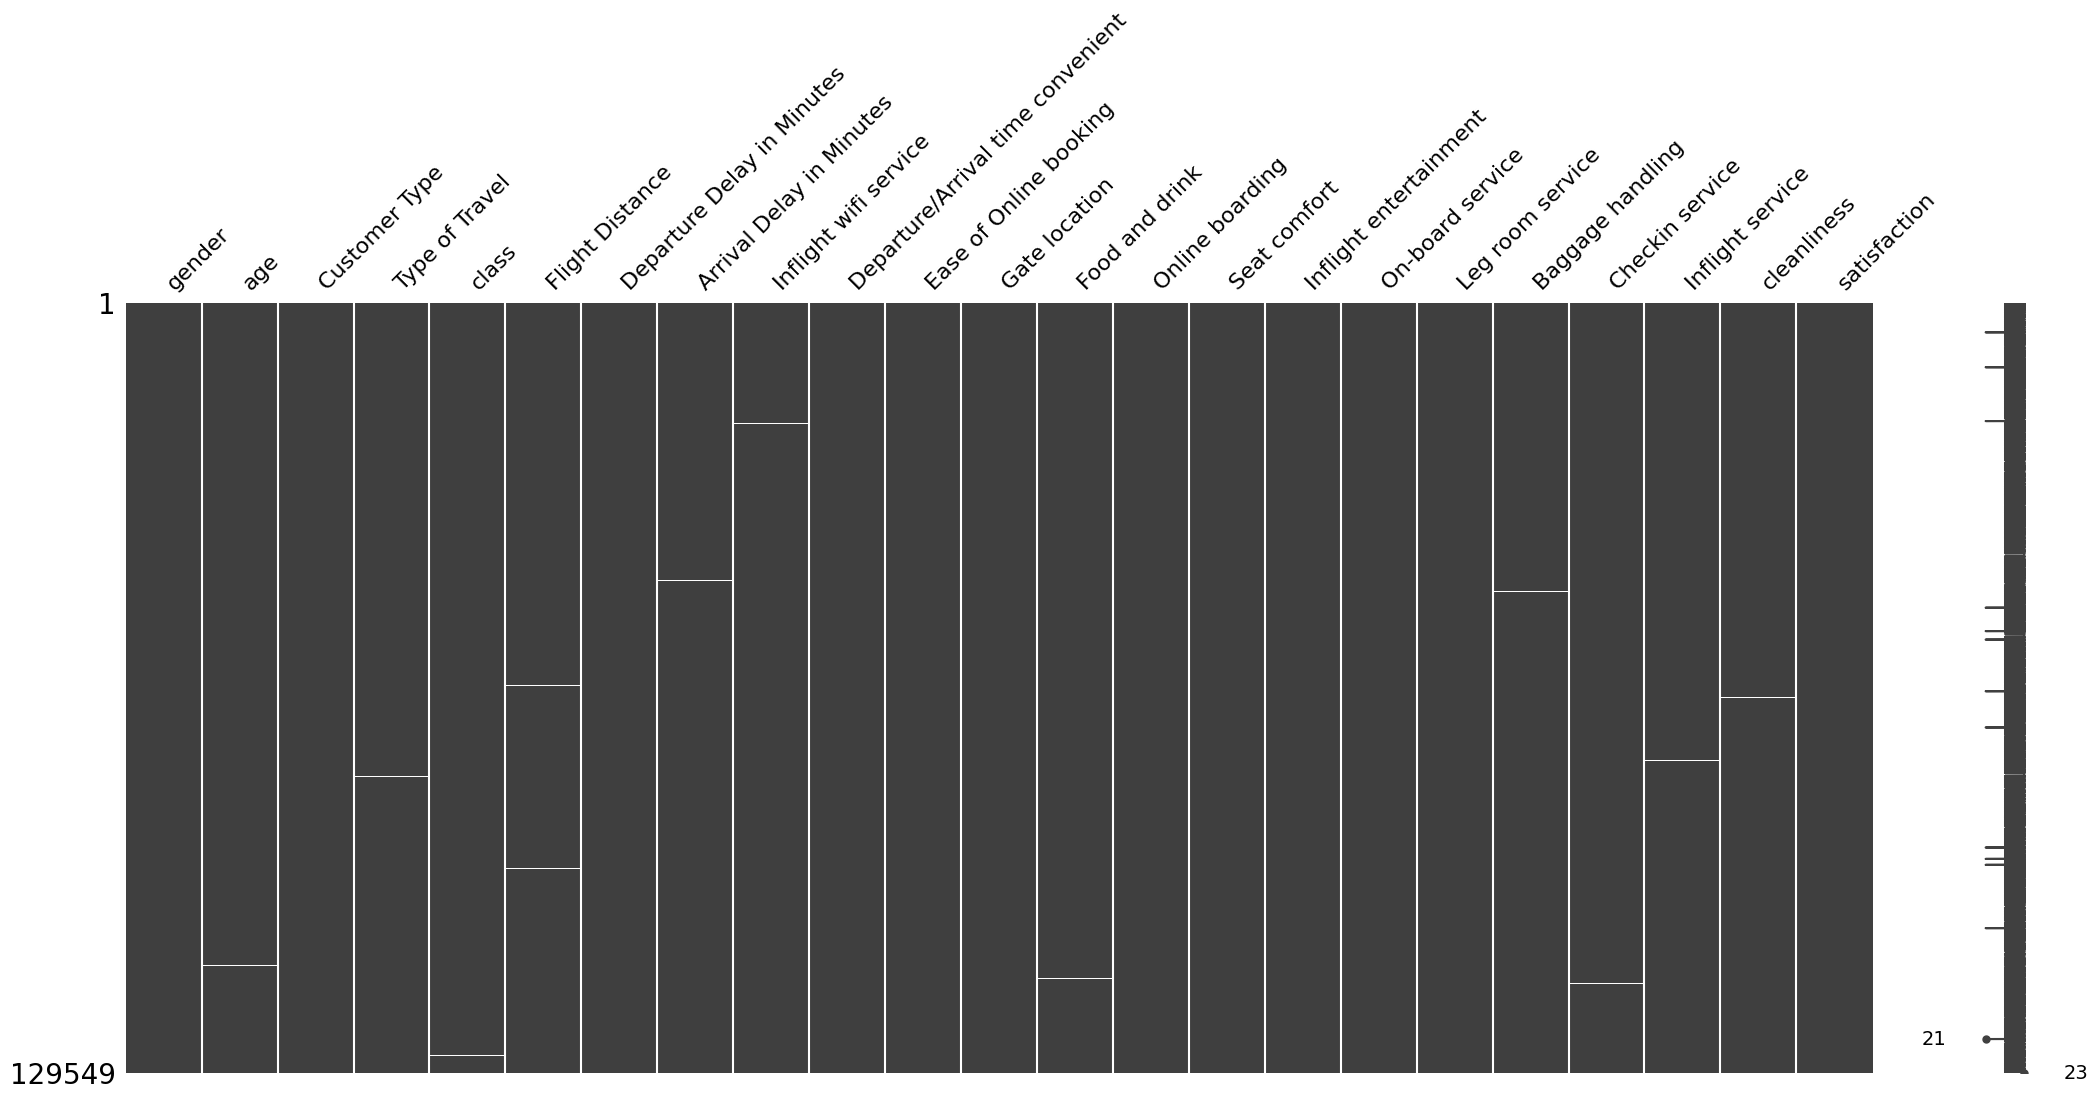

In [16]:
msno.matrix(df)
plt.show()

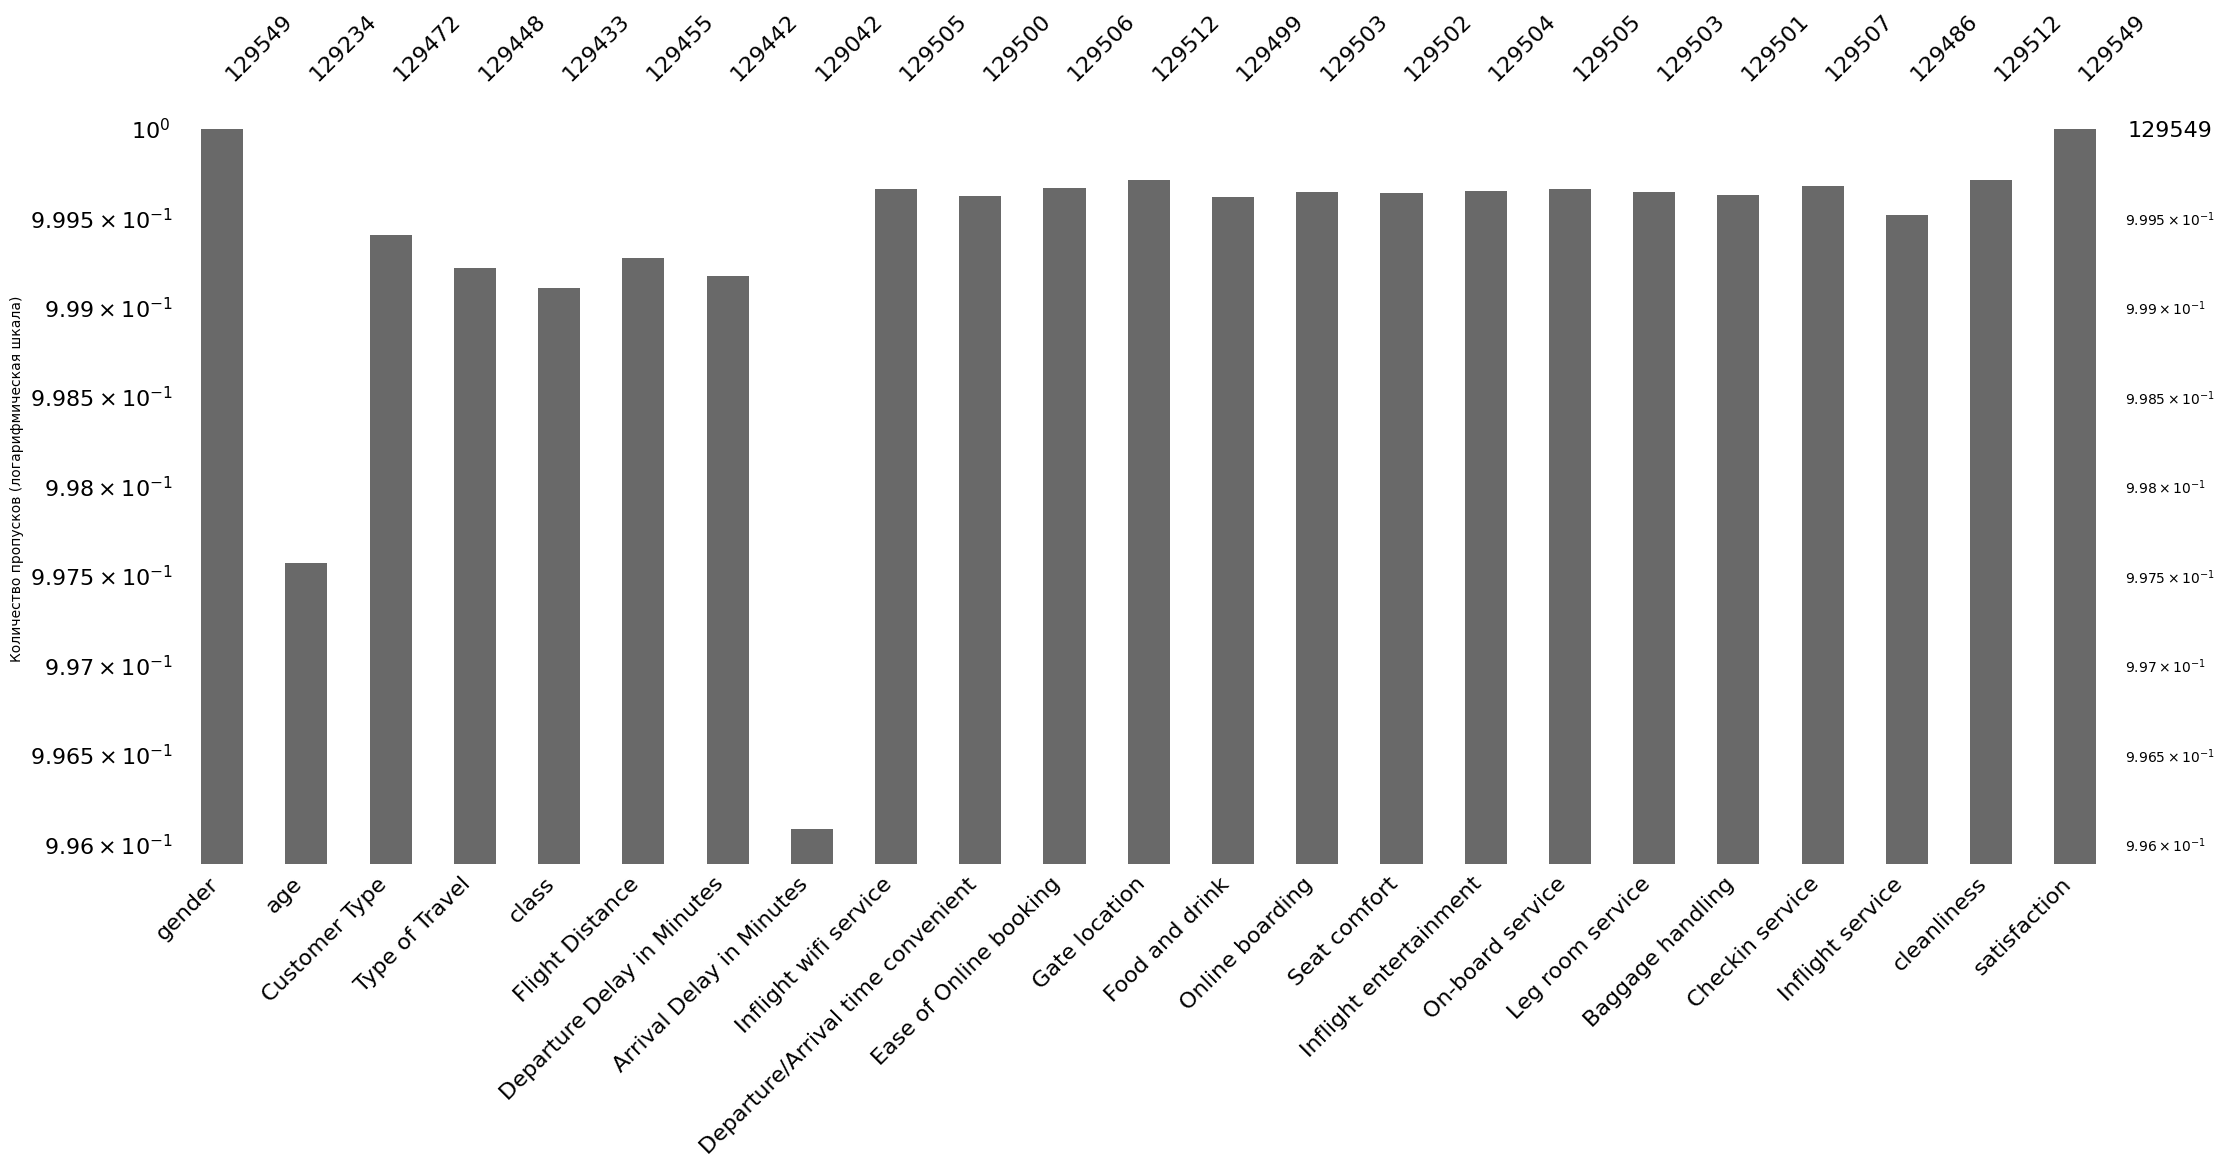

In [17]:
ax = msno.bar(df, log=True)
ax.set_ylabel("Количество пропусков (логарифмическая шкала)")
plt.show()

In [18]:
for col in df.columns:
    s = 0
    s = len(df[df[col]=='-'])
    print(f'{col}: {s}')

gender: 0
age: 0
Customer Type: 0
Type of Travel: 0
class: 0
Flight Distance: 0
Departure Delay in Minutes: 0
Arrival Delay in Minutes: 0
Inflight wifi service: 0
Departure/Arrival time convenient: 0
Ease of Online booking: 0
Gate location: 0
Food and drink: 0
Online boarding: 0
Seat comfort: 0
Inflight entertainment: 0
On-board service: 0
Leg room service: 0
Baggage handling: 0
Checkin service: 0
Inflight service: 0
cleanliness: 0
satisfaction: 25905


Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [19]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
7         Male  43.0     Loyal Customer  Business travel  Business   
13        Male  24.0  disloyal Customer  Business travel       Eco   
18      Female  61.0     Loyal Customer  Personal Travel       Eco   
31        Male  35.0  disloyal Customer  Business travel  Business   
39      Female  46.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129831  Female  28.0     Loyal Customer  Personal Travel       Eco   
129837    Male  66.0     Loyal Customer  Personal Travel       Eco   
129838  Female  59.0     Loyal Customer  Personal Travel       Eco   
129839    Male  61.0     Loyal Customer  Personal Travel       Eco   
129846    Male  44.0     Loyal Customer  Personal Travel       Eco   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
7                1963.0                         0.0                       0.0   
13                453.0                        16.0                      30.0   
18                821.0                         0.0                       0.0   
31                212.0                         0.0                       0.0   
39                 67.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129831            447.0                        23.0                      16.0   
129837            337.0                       199.0                     213.0   
129838            308.0                        32.0                      24.0   
129839            337.0                         0.0                       0.0   
129846            447.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
7                         3.0                                3.0  ...   
13                        2.0                                2.0  ...   
18                        2.0                                5.0  ...   
31                        2.0                                2.0  ...   
39                        3.0                                3.0  ...   
...                       ...                                ...  ...   
129831                    1.0                                3.0  ...   
129837                    2.0                                4.0  ...   
129838                    3.0                                5.0  ...   
129839                    2.0                                4.0  ...   
129846                    2.0                                5.0  ...   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
7                   4.0           5.0                     5.0   
13                  2.0           5.0                     5.0   
18                  1.0           5.0                     5.0   
31                  2.0           2.0                     2.0   
39                  5.0           4.0                     4.0   
...                 ...           ...                     ...   
129831              1.0           3.0                     3.0   
129837              5.0           5.0                     5.0   
129838              5.0           5.0                     3.0   
129839              2.0           3.0                     3.0   
129846              2.0           5.0                     5.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                              
7                    5.0               5.0               5.0              4.0   
13  

In [20]:
assert df_train.shape == (103_644, 23)

In [21]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age   Customer Type   Type of Travel     class  \
id                                                                
55        Male  36.0  Loyal Customer  Business travel  Business   
79      Female  70.0  Loyal Customer  Personal Travel       Eco   
126       Male  66.0  Loyal Customer  Personal Travel       Eco   
199     Female  60.0  Loyal Customer  Business travel  Business   
263       Male  43.0  Loyal Customer  Personal Travel  Business   
...        ...   ...             ...              ...       ...   
129750    Male  38.0  Loyal Customer  Business travel       Eco   
129771    Male  16.0  Loyal Customer  Personal Travel       Eco   
129798  Female  43.0  Loyal Customer  Personal Travel       Eco   
129868    Male  47.0  Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0  Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
55               3655.0                        40.0                      71.0   
79                108.0                        50.0                      41.0   
126               562.0                        88.0                      84.0   
199              3756.0                        36.0                      24.0   
263               802.0                         0.0                       0.0   
...                 ...                         ...                       ...   
129750            337.0                        92.0                      82.0   
129771            308.0                         2.0                       0.0   
129798            308.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129876            447.0                         2.0                       3.0   

        Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                                ...   
55                        1.0                                1.0  ...   
79                        5.0                                4.0  ...   
126                       2.0                                5.0  ...   
199                       4.0                                4.0  ...   
263                       1.0                                2.0  ...   
...                       ...                                ...  ...   
129750                    4.0                                3.0  ...   
129771                    3.0                                4.0  ...   
129798                    2.0                                4.0  ...   
129868                    3.0                                4.0  ...   
129876                    4.0                                4.0  ...   

        Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                              
55                 1.0              3.0           3.0                     3.0   
79                 4.0              4.0           4.0                     3.0   
126                5.0              2.0           5.0                     5.0   
199                2.0              4.0           5.0                     4.0   
263                2.0              3.0           3.0                     2.0   
...                ...              ...           ...                     ...   
129750             4.0              5.0           4.0                     4.0   
129771             1.0              3.0           5.0                     1.0   
129798             3.0              5.0           5.0                     4.0   
129868             4.0              3.0           4.0                     4.0   
129876             4.0              4.0           1.0                     4.0   

        On-board service  Leg room service  Baggage handling  Checkin service 

In [22]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=RANDOM_STATE)

In [24]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [25]:
for col in X_train.columns:
    mode_value = X_train[col].mode()[0]
    X_train.fillna({col: mode_value}, inplace=True)
for col in X_val.columns:
    mode_value = X_val[col].mode()[0]
    X_val.fillna({col: mode_value}, inplace=True)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [26]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [27]:
df.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   129549          129472           129448    129433   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

In [28]:
X_train.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  72550.000000     72550.000000                72550.000000   
mean      40.098856      1329.018332                   15.859366   
std       20.658196      4764.369357                   70.861937   
min        0.000000         0.000000                    0.000000   
25%       27.000000       413.000000                    0.000000   
50%       40.000000       844.000000                    0.000000   
75%       51.000000      1744.000000                   12.000000   
max      544.000000    379620.000000                 9282.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count              72550.000000           72550.000000   
mean                  16.645968               2.733687   
std                   97.990293               1.362172   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                11760.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                       72550.000000            72550.000000   
mean                            3.065017                2.761006   
std                             1.552254                1.414843   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               28.000000   

       Gate location  Food and drink  Online boarding  Seat comfort  \
count   72550.000000    72550.000000     72550.000000  72550.000000   
mean        2.982688        3.209318         3.256513      3.445665   
std         1.316648        1.349963         1.372739      1.346077   
min         0.000000        0.000000         0.000000      0.000000   
25%         2.000000        2.000000         2.000000      2.000000   
50%         3.000000        3.000000         3.000000      4.000000   
75%         4.000000        4.000000         4.000000      5.000000   
max        36.000000       36.000000        32.000000     45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count            72550.000000      72550.000000      72550.000000   
mean                 3.362150          3.383101          3.352364   
std                  1.360862          1.333758          1.360180   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 40.000000         45.000000         36.000000   

       Baggage handling  Checkin service  Inflight service   cleanliness  
count      72550.000000     72550.000000      72550.000000  72550.000000  
mean           3.630255         3.309056          3.640234      3.291178  
std            1.227853         1.293114          1.215114      1.343302  
min            0.000000         0.000000          0.000000      0.000000  
25%            3.000000         3.000000          3.000000      2.000000  
50%            4.000000         3.000000          4.000000      3.000000  
75%            5.000000         4.000000          5.000000      4.000000  
max           40.000000        45.000000         36.000000     45.000000

In [29]:
X_train.describe(include='object')

gender   Customer Type   Type of Travel     class
count    72550           72550            72550     72550
unique       2               2                2         3
top     Female  Loyal Customer  Business travel  Business
freq     36816           59406            50054     34793

Первое, что бросается в глаза - это то, что данные не масштабированные. Также видно в исходной таблице, что есть пропуски, после заполнения пропусков модой, ни в одном столбце больше пропусков не наблюдается. Наблюдаются выбросы почти во всех колонках - сильная разница между max и третьим квартилем. Наблюдается дисбаланс в классах категориальных столбцах. Данные хорошо перемешаны, в тренировачную выборку попали все уникальные классы категориальных столбцов.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [30]:
X_train.select_dtypes(include=['float']).columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness'],
      dtype='object')

In [31]:
X_train['Departure Delay in Minutes'].value_counts()

Departure Delay in Minutes
0.0      40837
1.0       2065
2.0       1574
3.0       1388
4.0       1289
         ...  
382.0        1
897.0        1
267.0        1
283.0        1
389.0        1
Name: count, Length: 440, dtype: int64

In [32]:
def remove_outliers(x_data, quantile=0.996):
    numeric_columns = x_data.select_dtypes(include=['float']).columns

    for col in numeric_columns:
        quantile_threshold = x_data[col].quantile(quantile)
        x_data = x_data[x_data[col] <= quantile_threshold]

    return x_data

X_train = remove_outliers(X_train)
X_val = remove_outliers(X_val)

In [33]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [34]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [35]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [36]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""

    for col in cols:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(x=col, data=df, hue=y, ax=ax)
        ax.set_title(f'Распределение {col}')
        ax.legend(title='Целевая переменная')
        plt.show()

In [37]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))

        sns.histplot(data=df, x=col, hue=y, ax=axes[0])
        axes[0].set_title(f'Гистограмма для {col}')
        axes[0].legend(y, title='Целевая переменная')


        sns.boxplot(data=df, x=col, hue=y, ax=axes[1])
        axes[1].set_title(f'Ящик с усами для {col}')
        axes[1].legend(title='Целевая переменная')

        plt.tight_layout()
        plt.show()

In [38]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.countplot(x=col, data=df, hue=y, ax=ax)
        ax.set_title(f'Распределение {col}')
        ax.legend(title='Целевая переменная')
        plt.show()

Отрисовка.

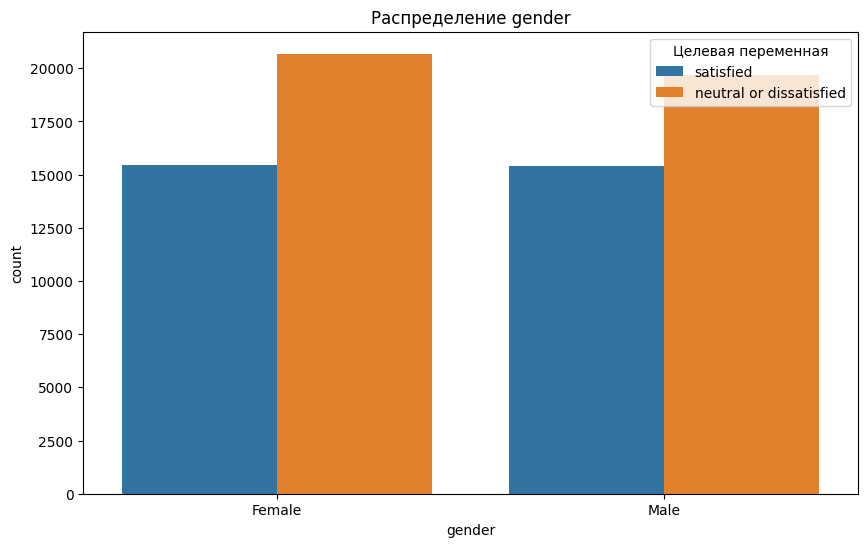

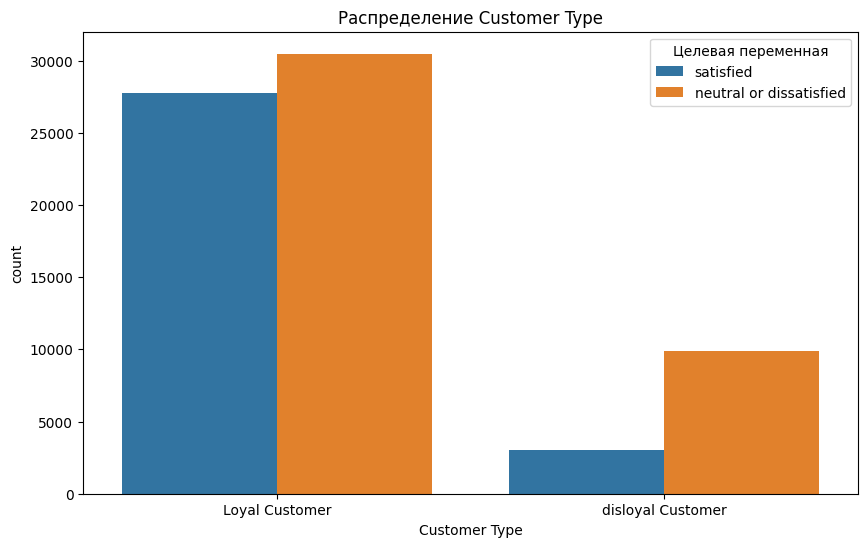

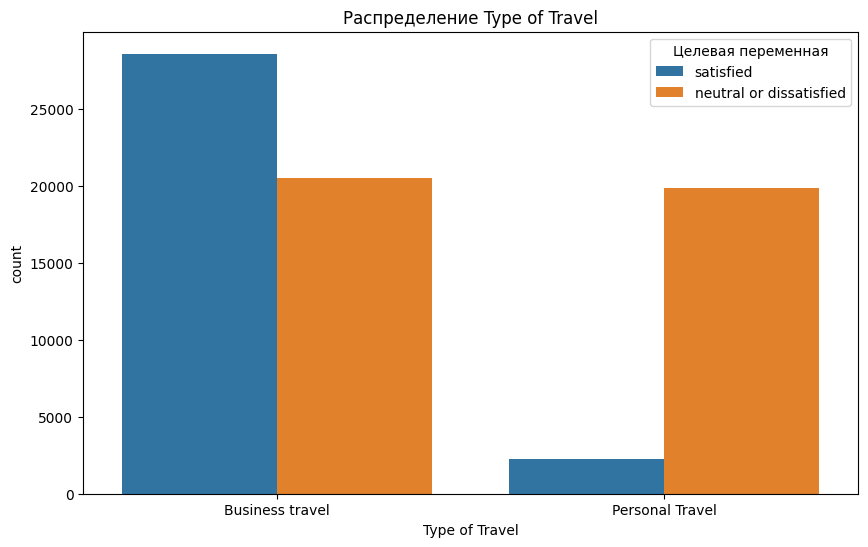

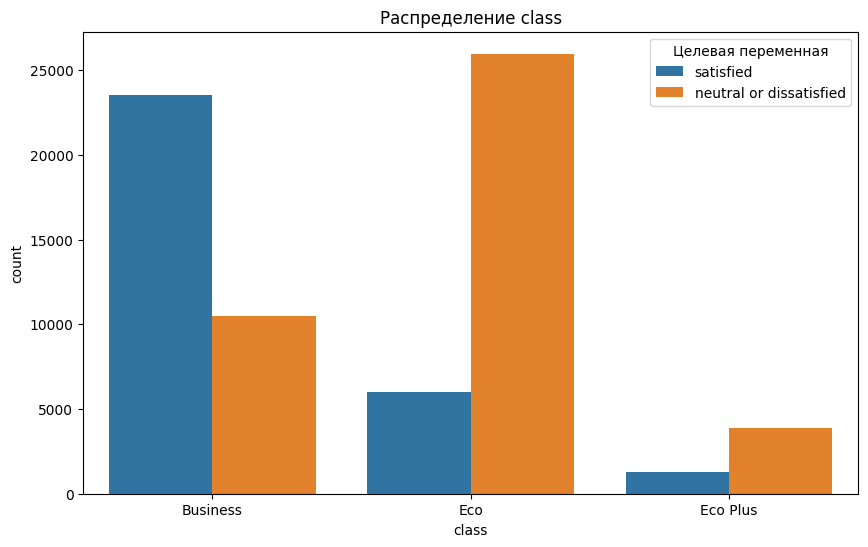

In [39]:
plot_categorical(categorical_cols, X_train, y_train)

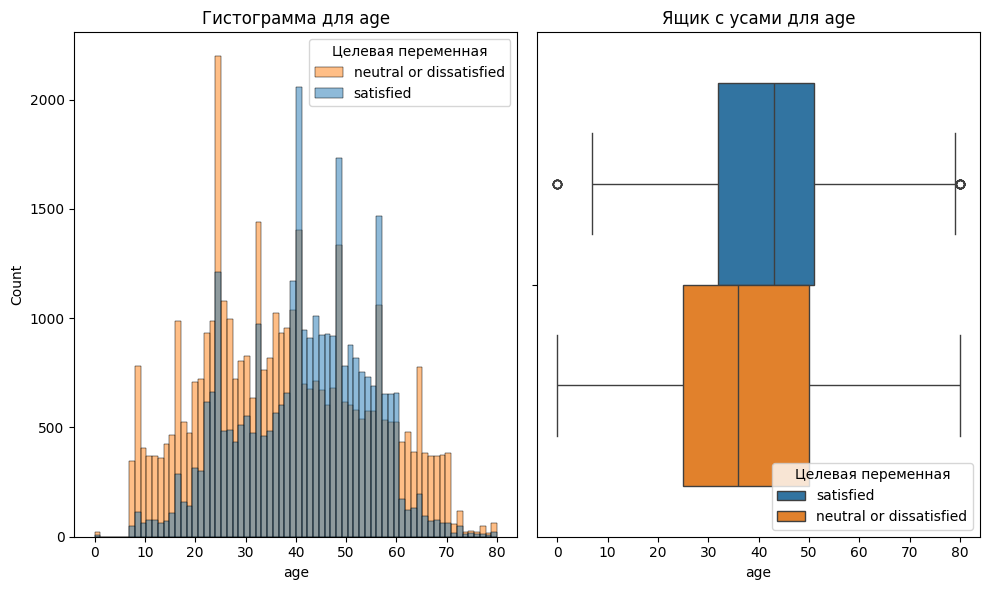

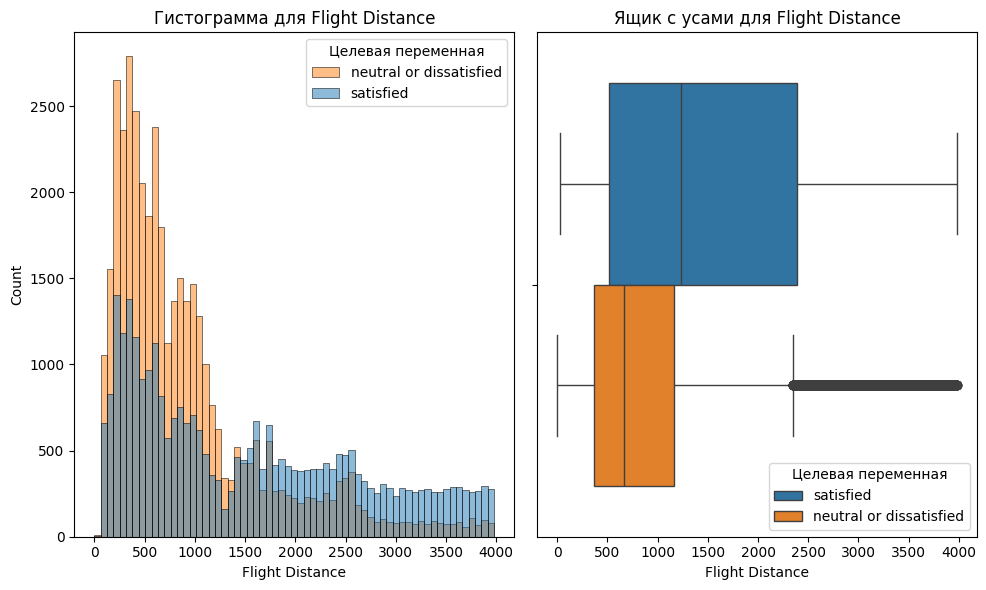

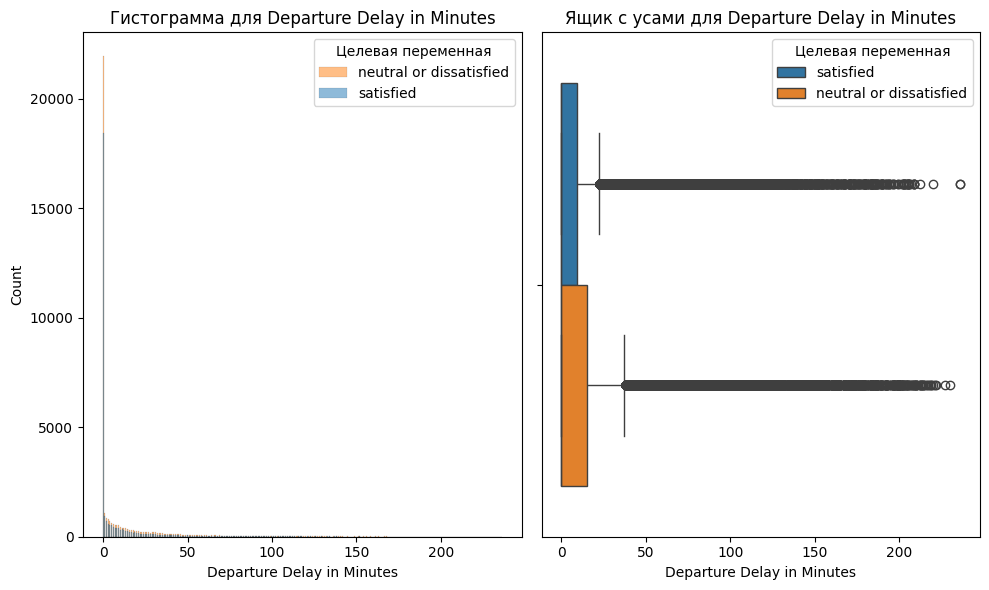

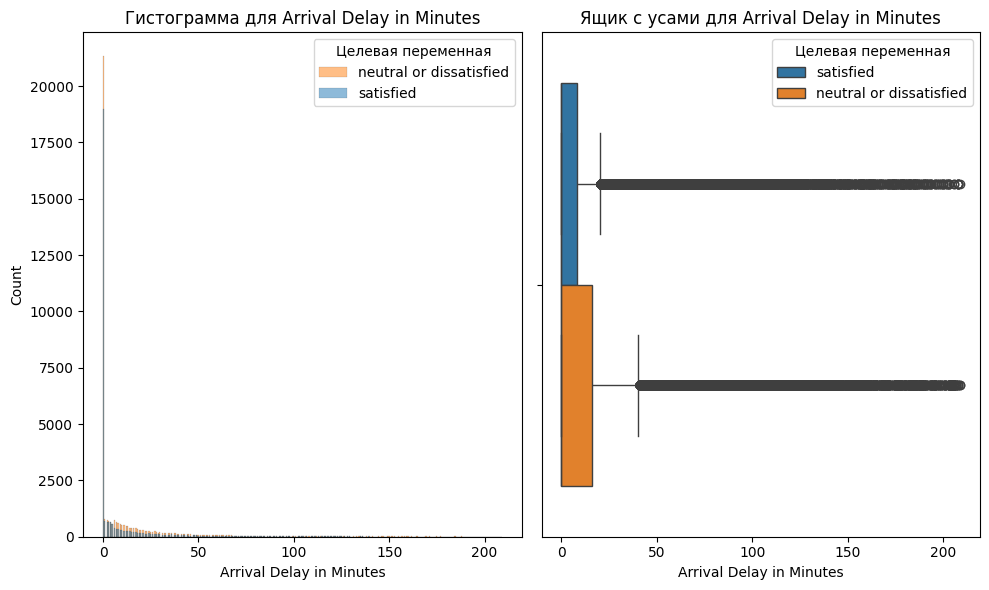

In [40]:
plot_continuous(continuous_cols, X_train, y_train)

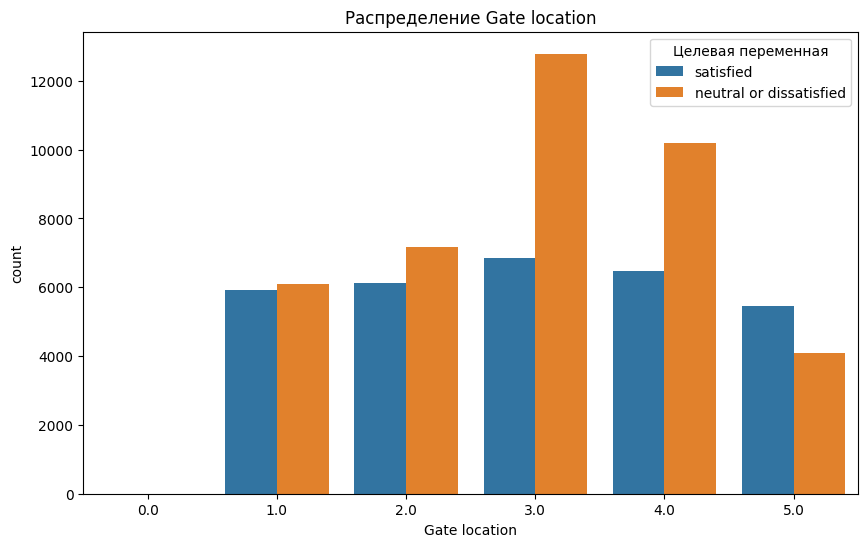

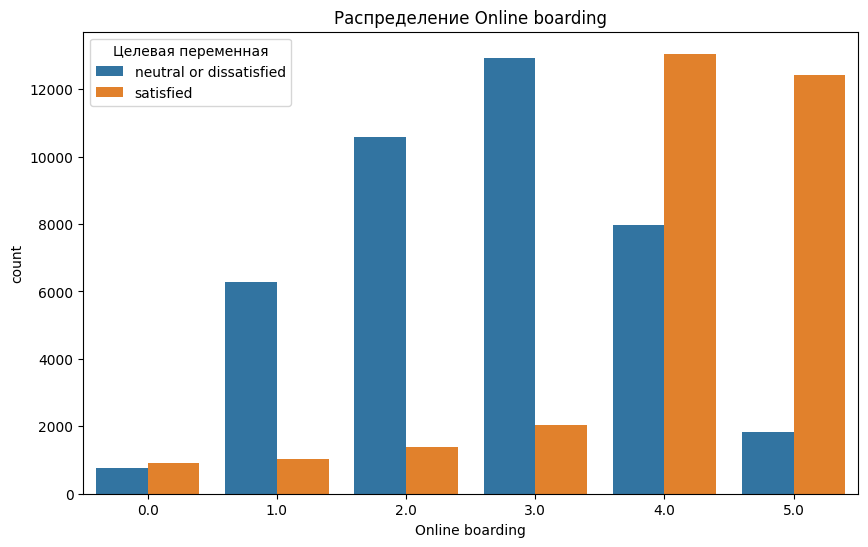

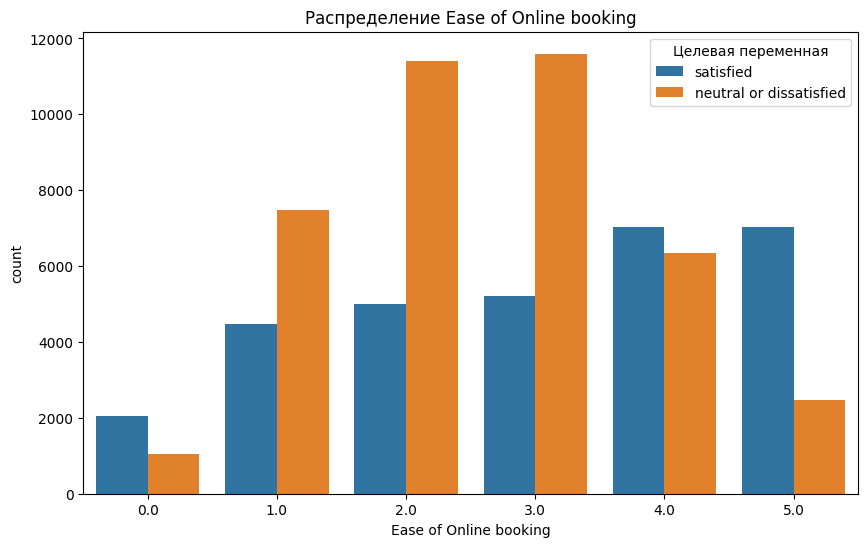

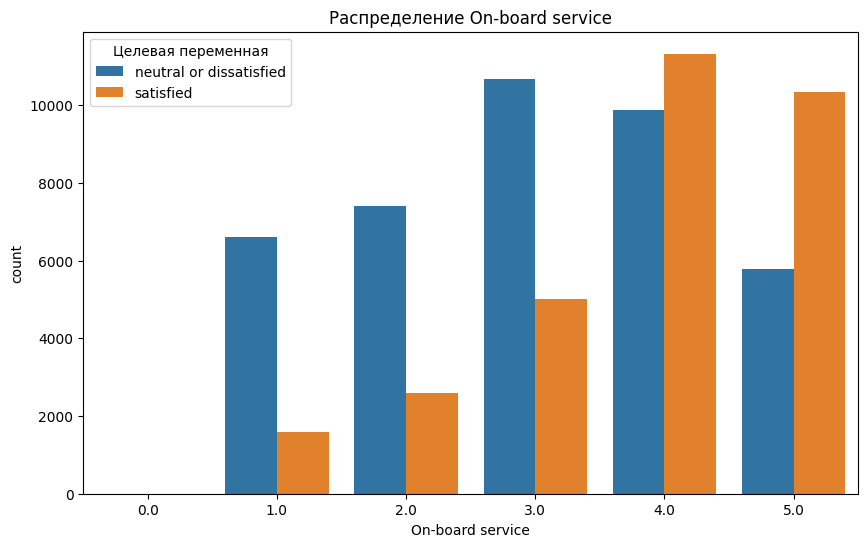

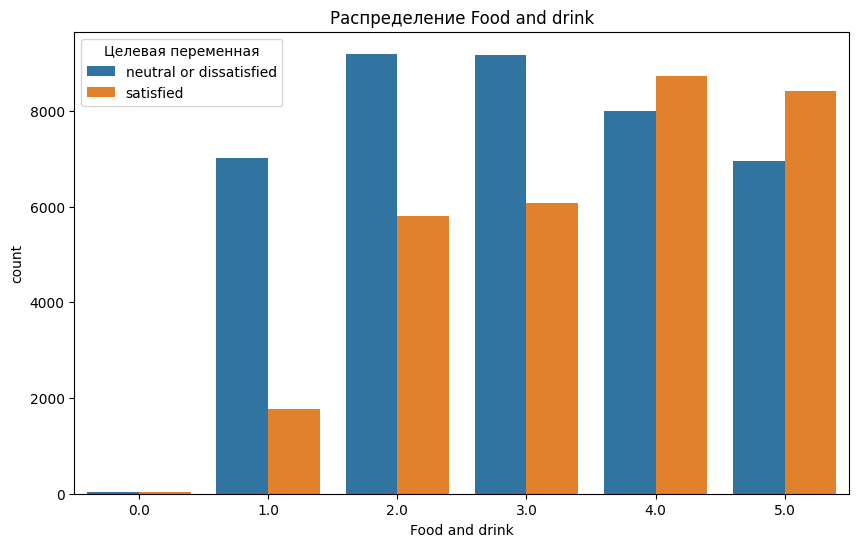

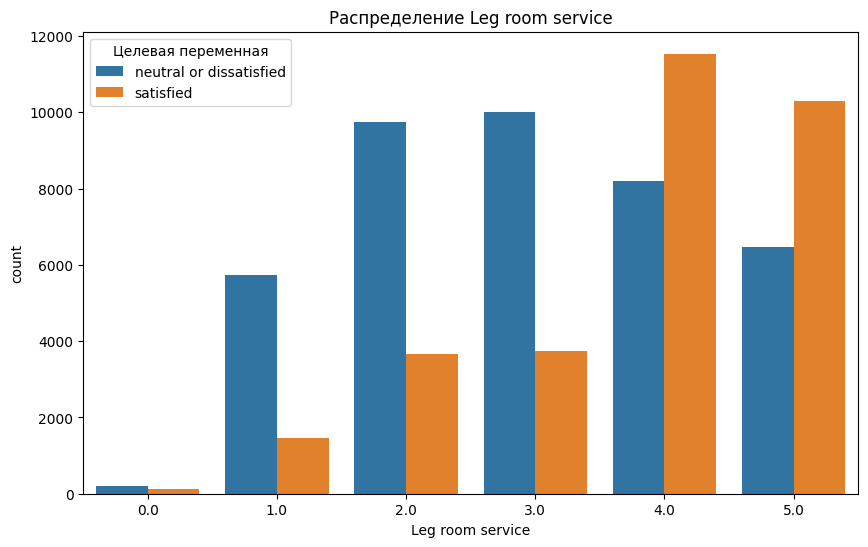

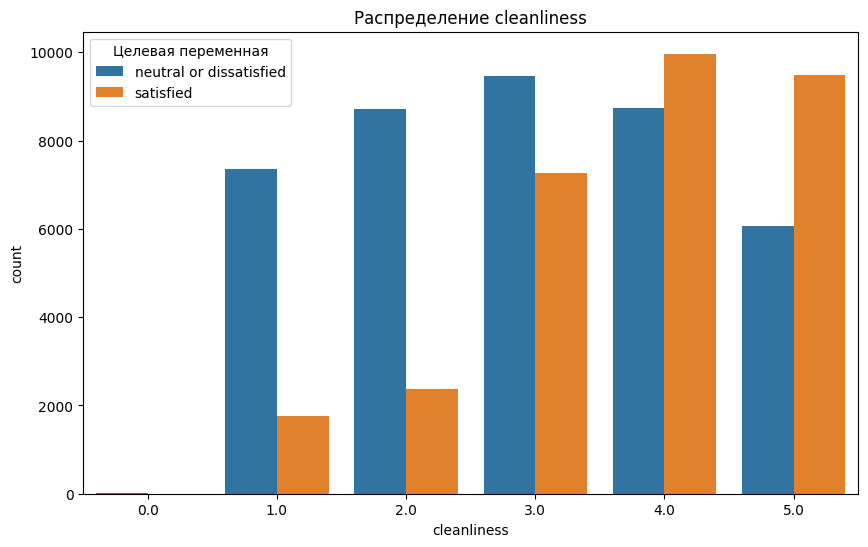

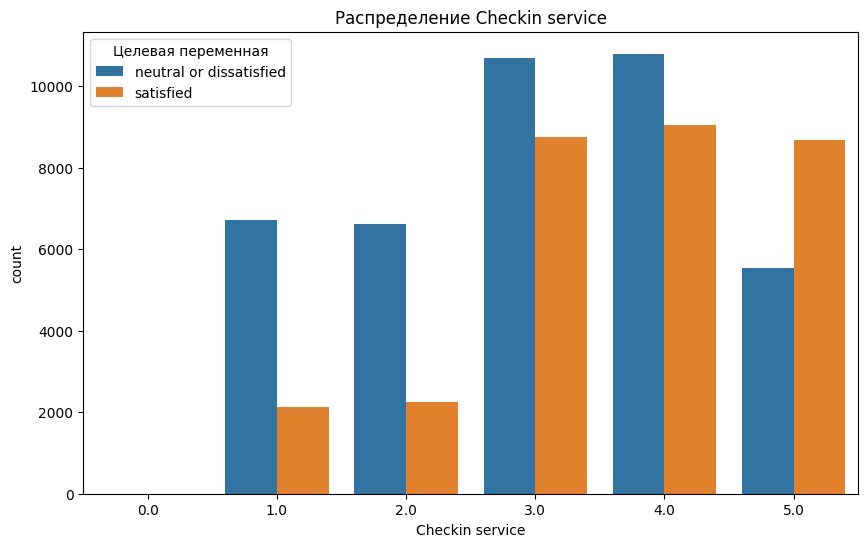

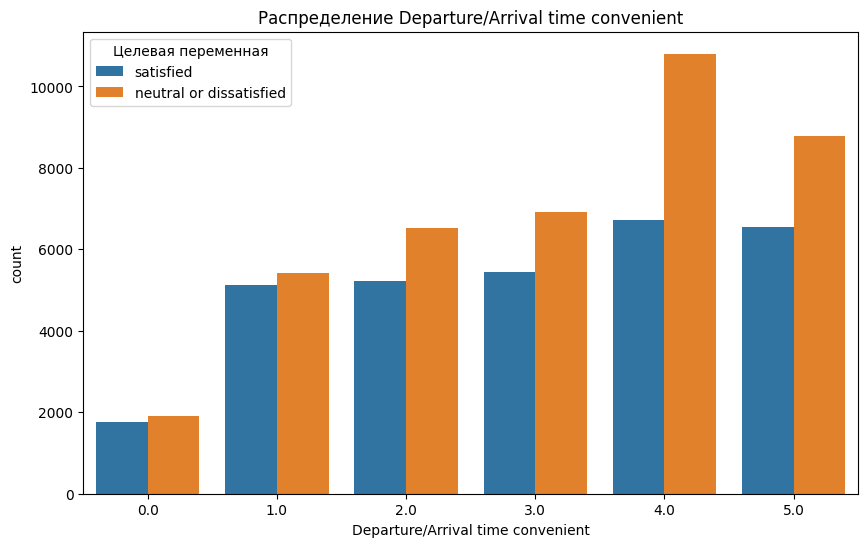

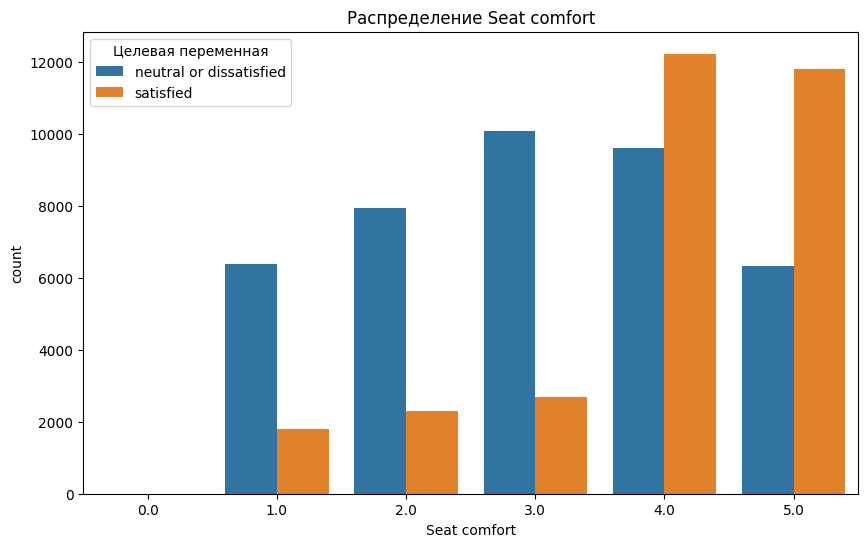

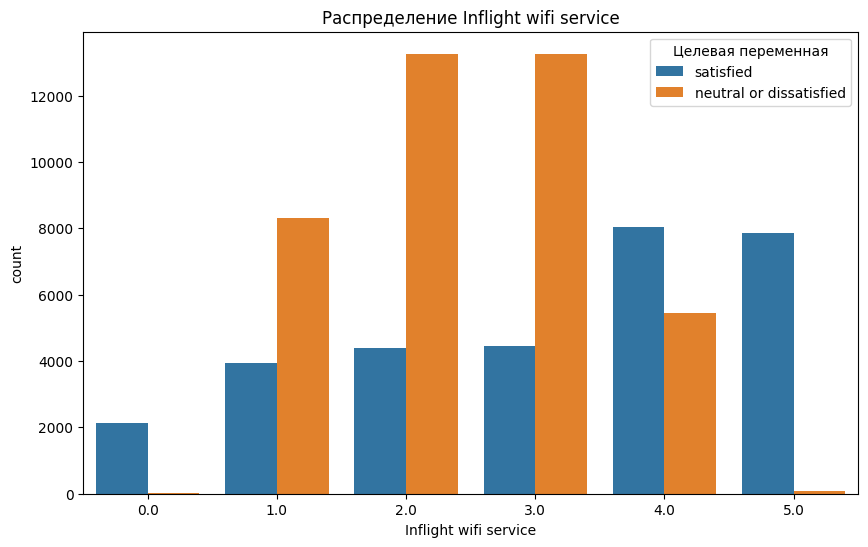

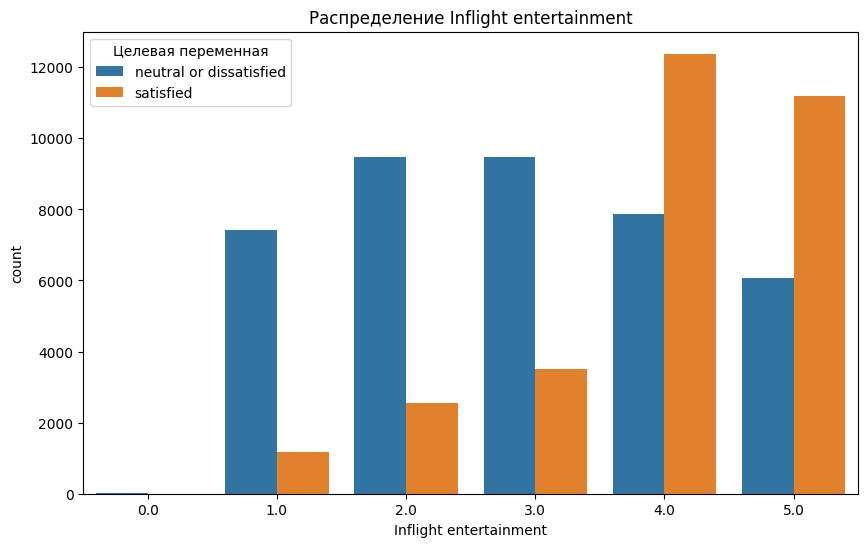

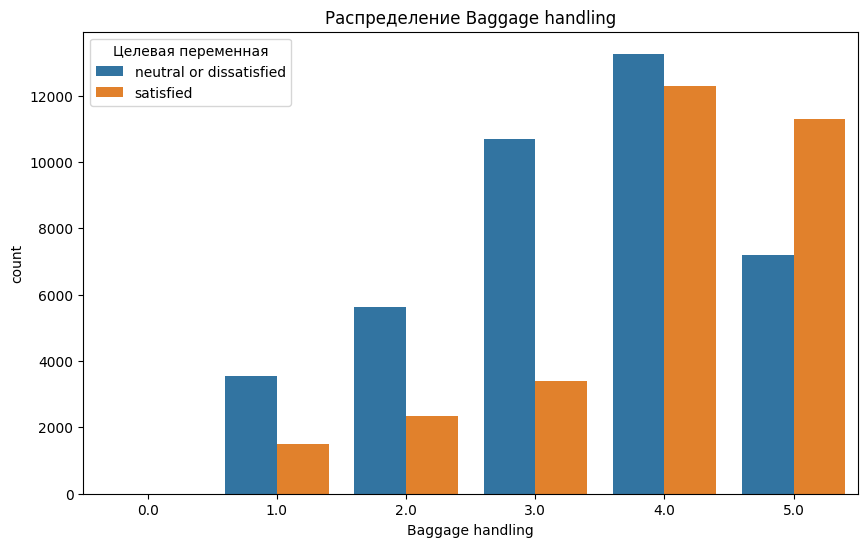

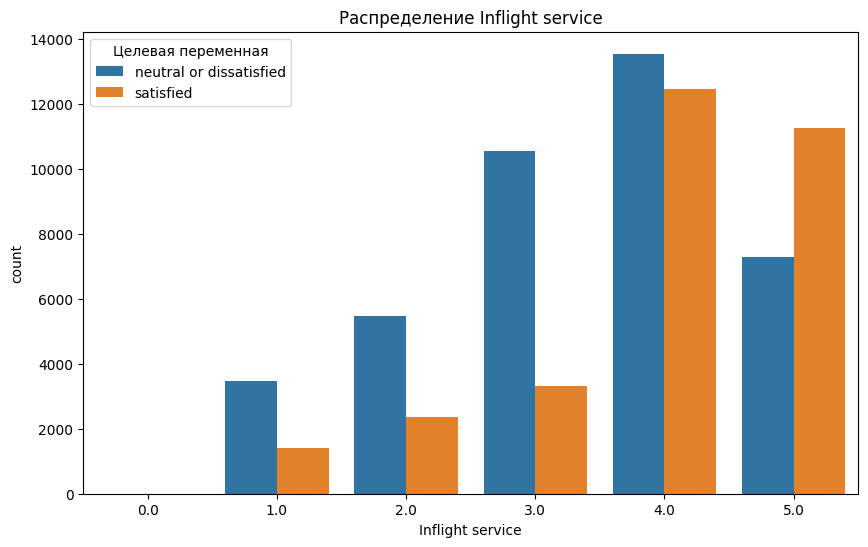

In [41]:
plot_ordinal(ordinal_cols, X_train, y_train)

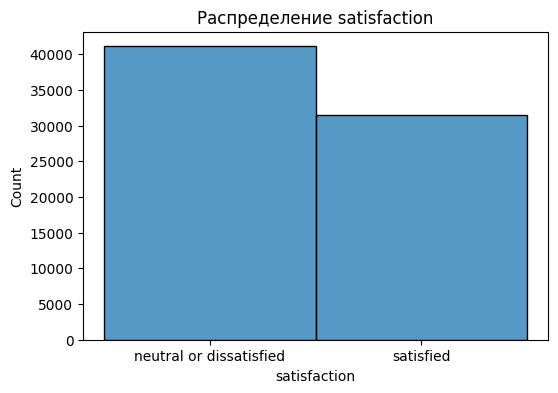

In [42]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=y_train)
ax.set_title(f'Распределение satisfaction')
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

###**`Выводы:`**

 - *По категориальным признакам:* наблюдается явный дисбаланс классов во всех категориальных переменных как по таргету, так и по самому распределению категорий внутри столбцов. Не наблюдается сильного диспаланса только в переменной `gender`.
 - *По континуальным признакам:* по гистограмме для возраста видно, что молодежь до 40 лет активно оценку `satisfied` не ставит. Путешественники, которым 40-60 лет, наоборот, в основном довольны полетом, а тем, кому 60+ внезапно почему-то тоже, как и молодежь, оставляют отрицательный или нейтральный отзыв. В целом график центрирован и похож на нормальное распределение. Все остальные абсолютно наоборот - классы несбалансированы и не отнормированны. На графиках `Departure Delay in Minutes` и `Arrival Delay in Minutes` видно, что количество задержек взлетов или прилетов на 0 минут значительно превосходит другие показатели, что несомненно радует.
 - *По порядковым признакам:* данные распределения - распределения оценок по каждому пункту оценивания. Почти везде наблюдается следующая зависимость - если человек поставил оценку 4 или 5, то он доволен поездкой, если от 0 до 3, то наоборот, не доволен, что логично. Здесь также можно найти зависимость между элементом оценивания и целевой переменной: то есть корреляцию между переменной и таргетом. Например, если человек поставил оценку 5, но при этом не доволен поездкой в целом, то, возможно, эта переменная слабо влияет на итоговую оценку. Например, в столбце `Departure/Arrival time convenient` наблюдается следующая картина: в оновном все ставят оценку 4 или 5, но при этом, несмотря на то, какую оценку поставил человек, он не доволен поездкой в целом.

 - *По целевой переменной:* сильного дисбаланса классов не наблюдается.


### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

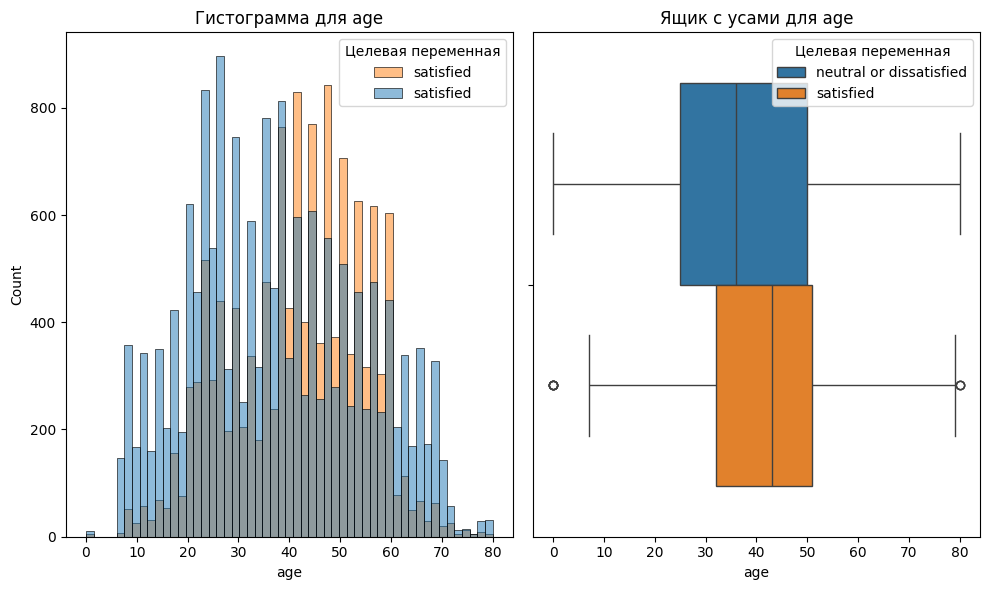

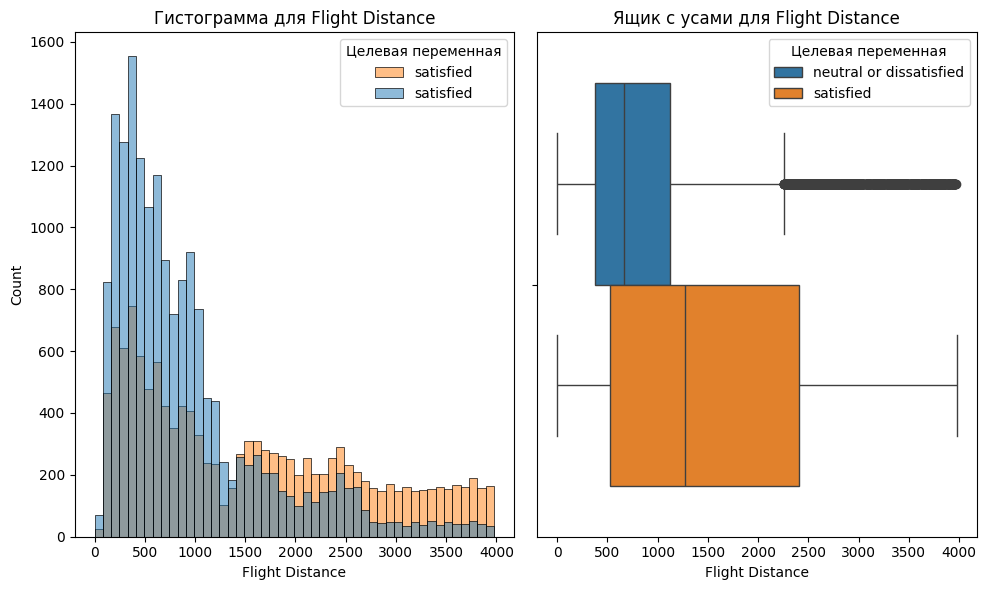

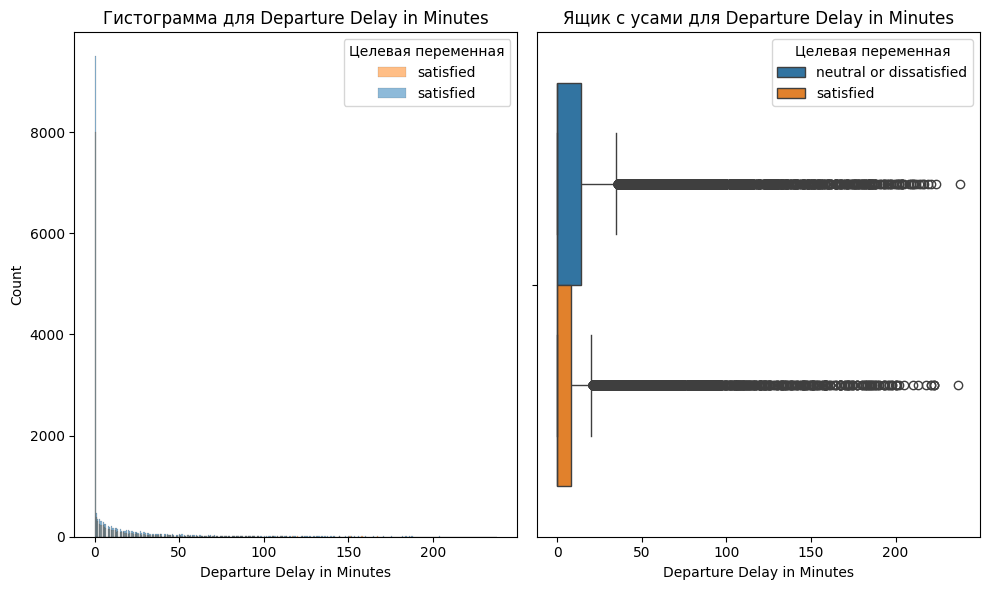

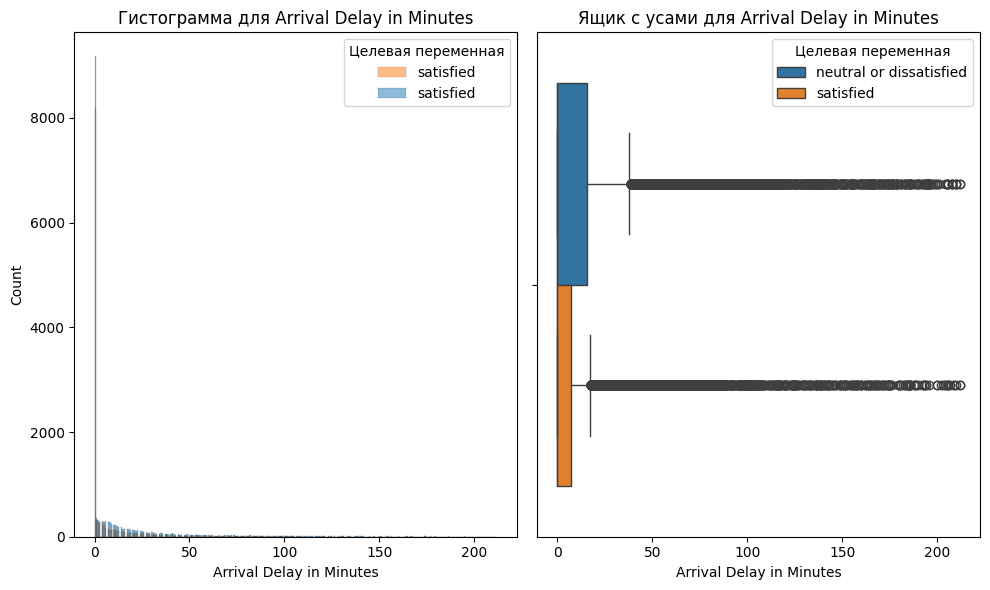

In [43]:
plot_continuous(continuous_cols, X_val, y_val)

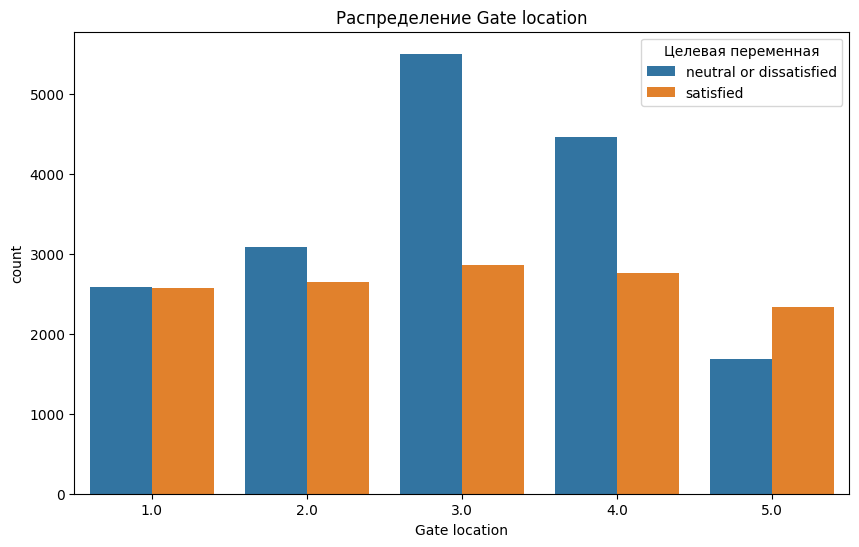

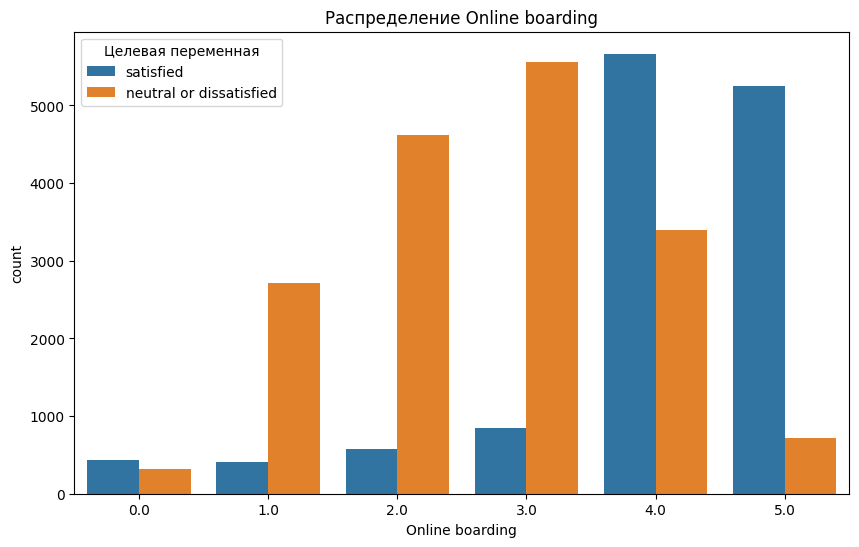

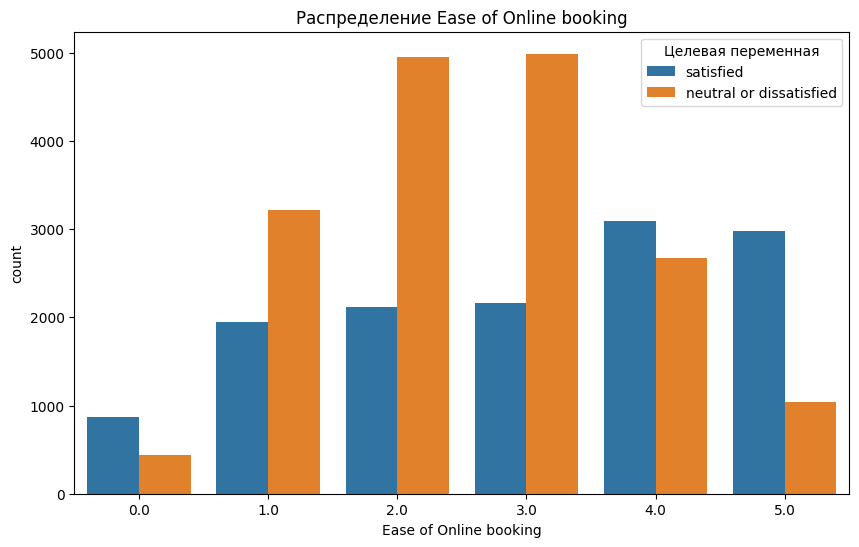

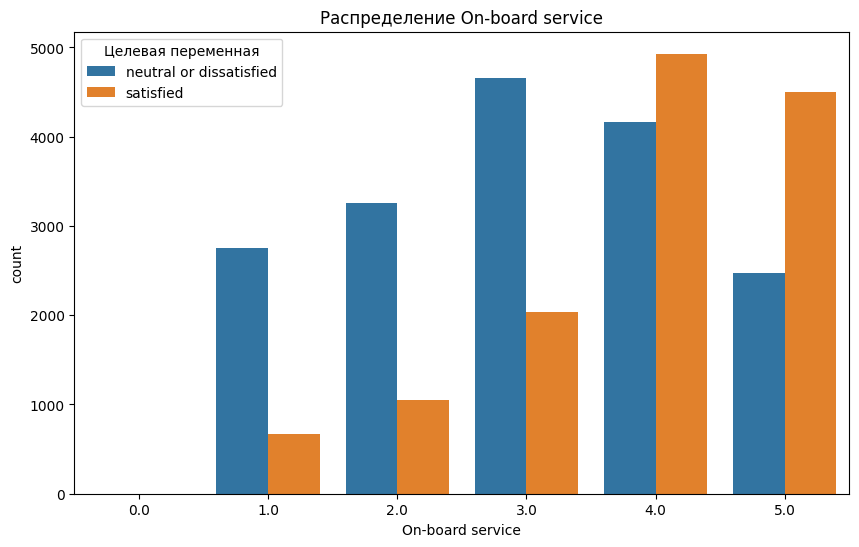

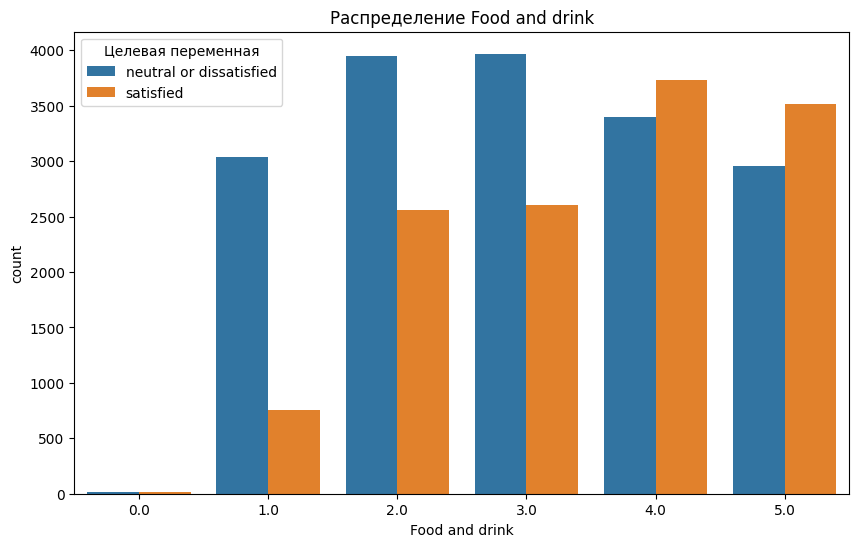

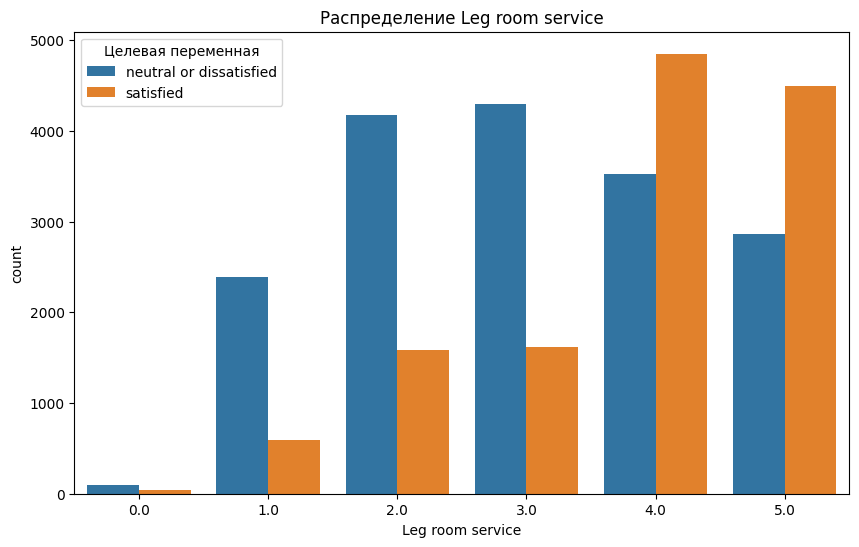

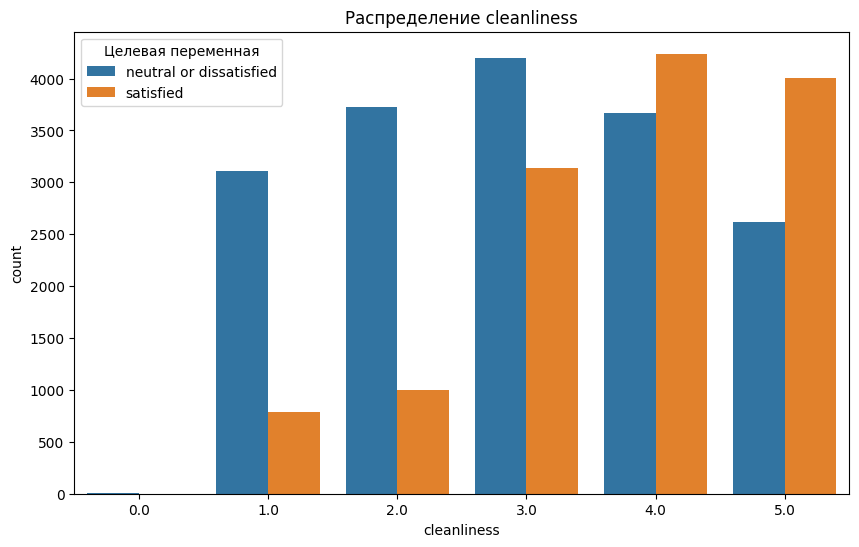

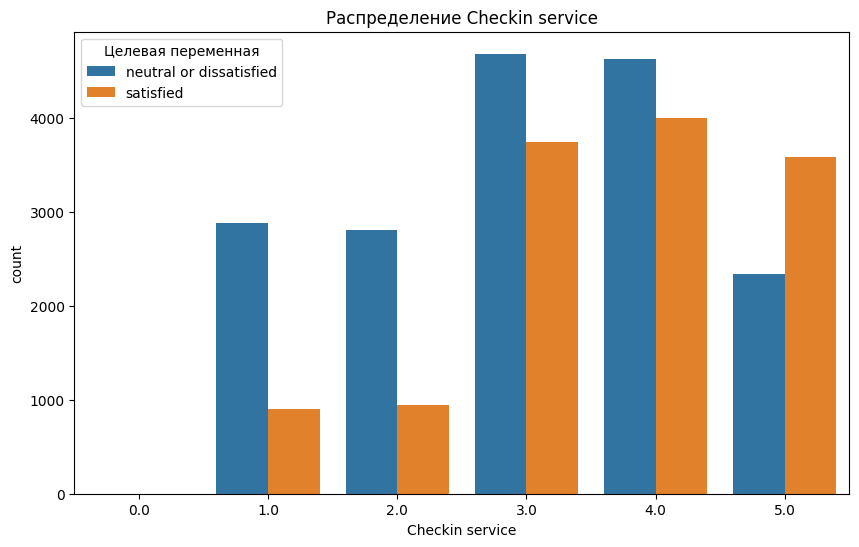

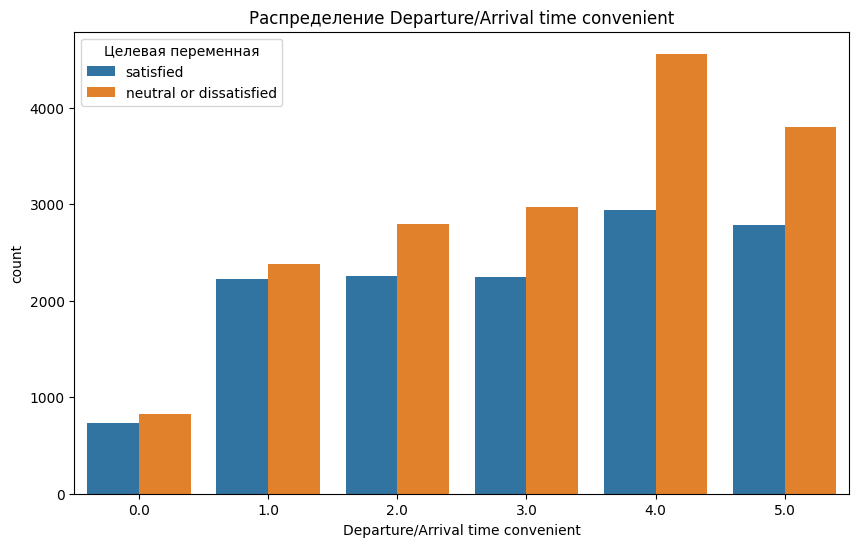

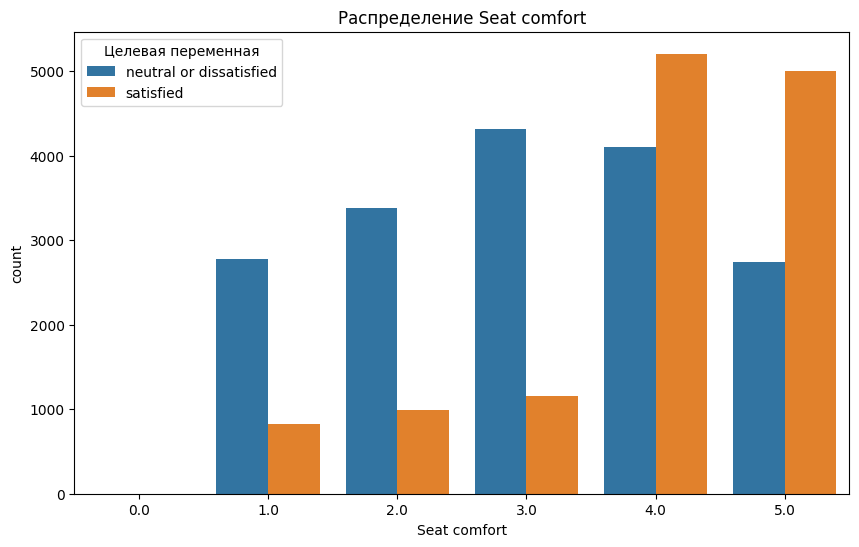

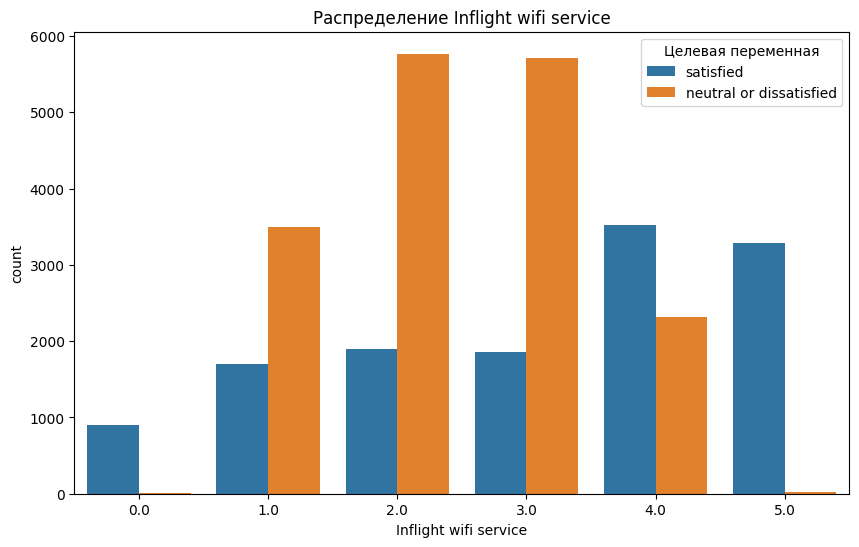

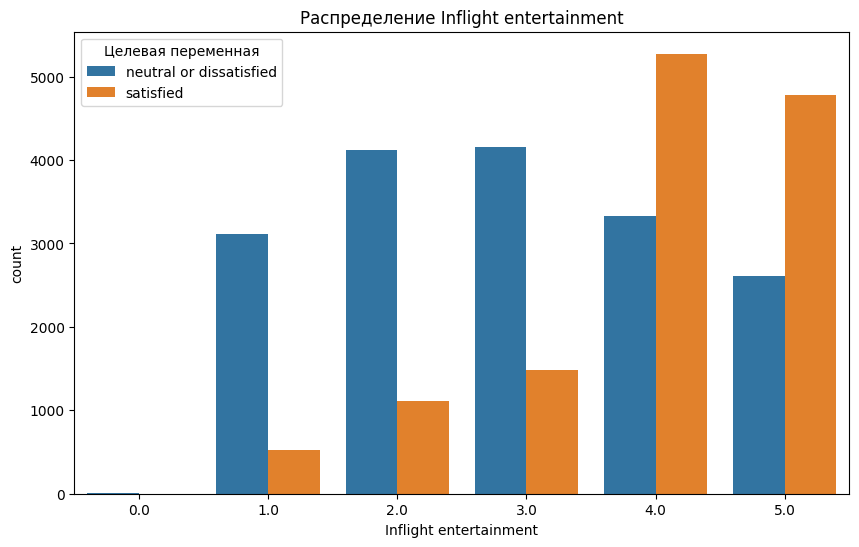

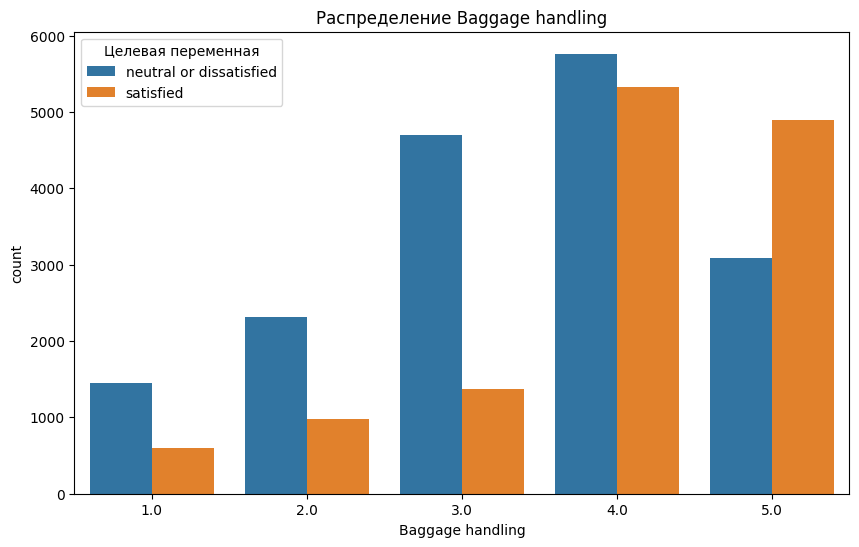

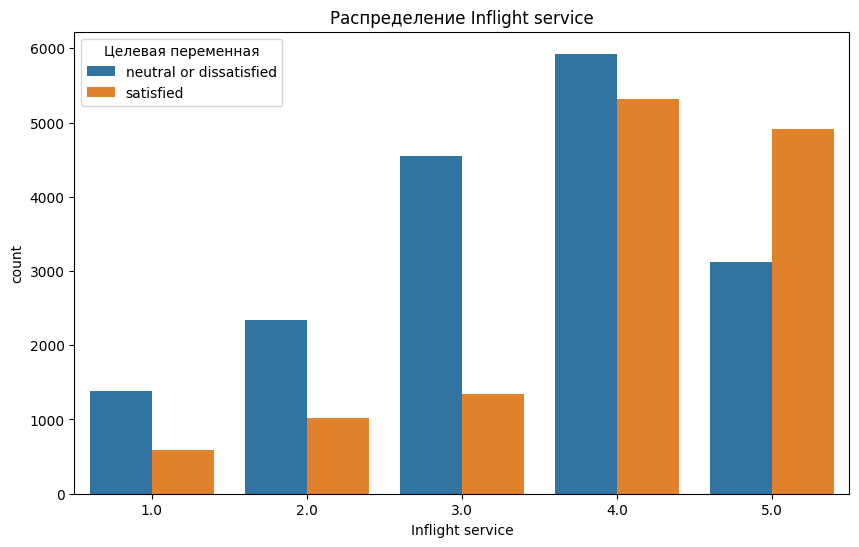

In [44]:
plot_ordinal(ordinal_cols, X_val, y_val)

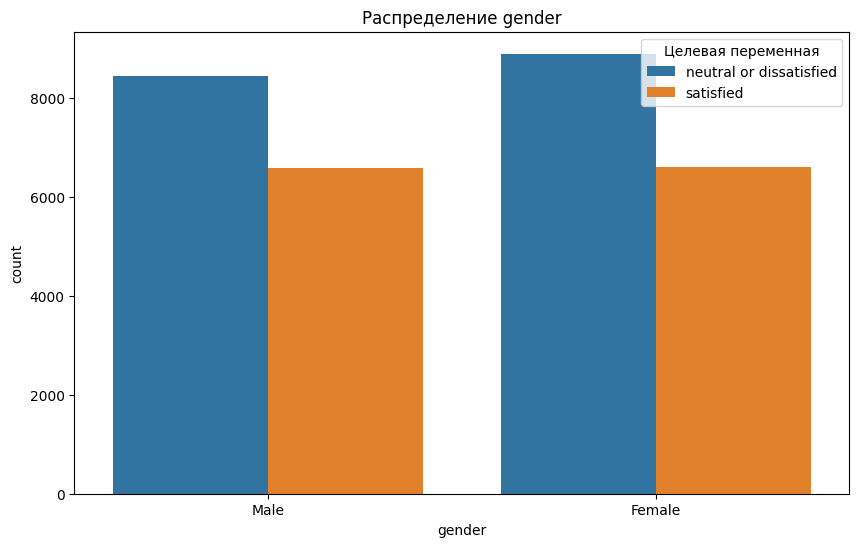

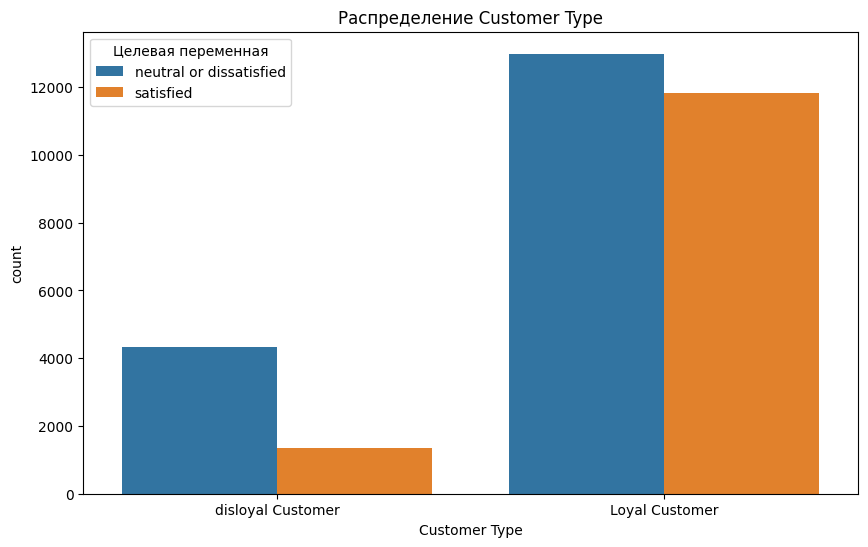

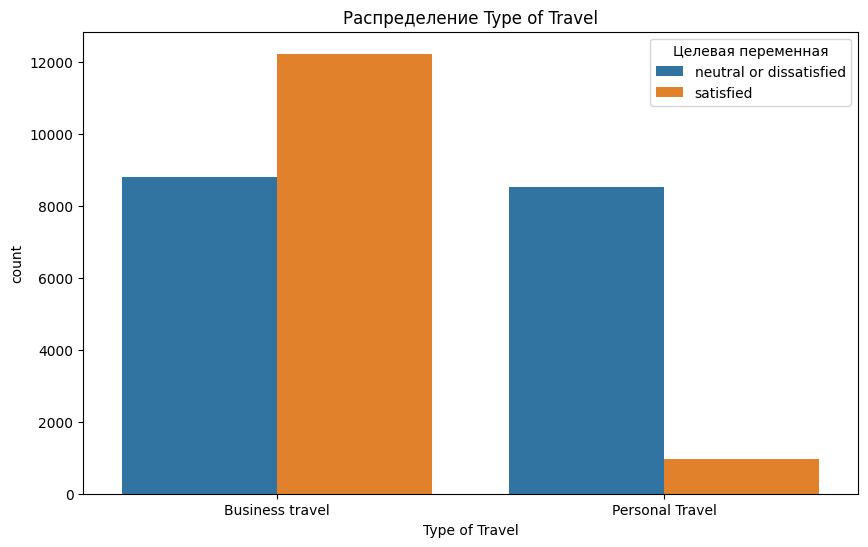

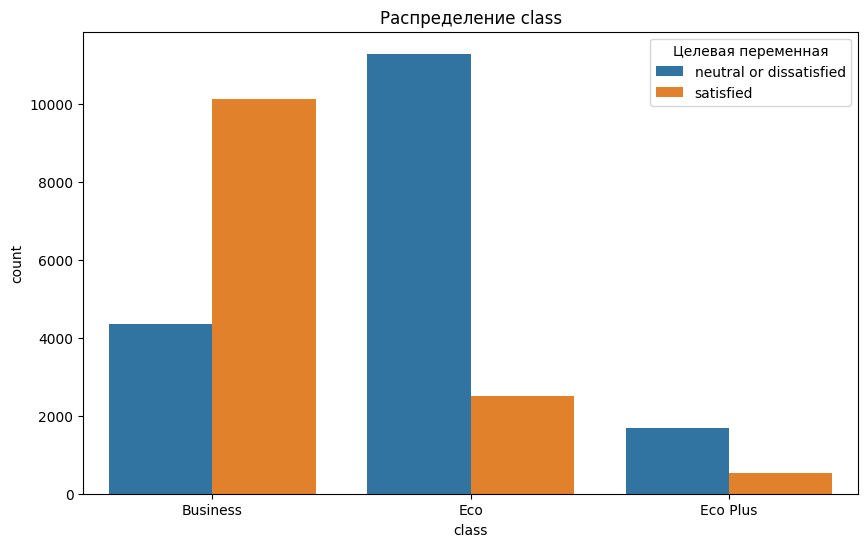

In [45]:
plot_categorical(categorical_cols, X_val, y_val)

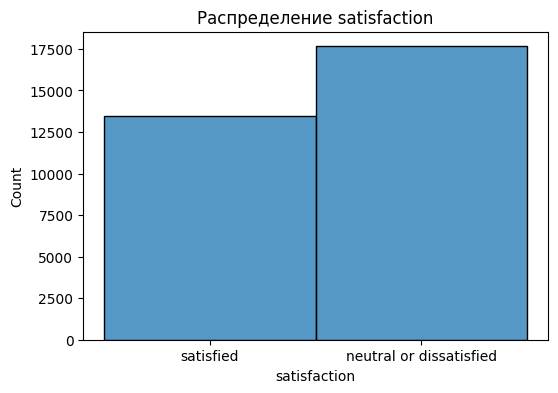

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=y_val)
ax.set_title(f'Распределение satisfaction')
plt.show()

In [47]:
df_test.head()

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
id                                                                              
55     Male  36.0  Loyal Customer  Business travel  Business           3655.0   
79   Female  70.0  Loyal Customer  Personal Travel       Eco            108.0   
126    Male  66.0  Loyal Customer  Personal Travel       Eco            562.0   
199  Female  60.0  Loyal Customer  Business travel  Business           3756.0   
263    Male  43.0  Loyal Customer  Personal Travel  Business            802.0   

     Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                          
55                         40.0                      71.0   
79                         50.0                      41.0   
126                        88.0                      84.0   
199                        36.0                      24.0   
263                         0.0                       0.0   

     Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                             ...   
55                     1.0                                1.0  ...   
79                     5.0                                4.0  ...   
126                    2.0                                5.0  ...   
199                    4.0                                4.0  ...   
263                    1.0                                2.0  ...   

     Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                           
55              1.0              3.0           3.0                     3.0   
79              4.0              4.0           4.0                     3.0   
126             5.0              2.0           5.0                     5.0   
199             2.0              4.0           5.0                     4.0   
263             2.0              3.0           3.0                     2.0   

     On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                           
55                3.0               3.0               1.0              4.0   
79                3.0               0.0               3.0              5.0   
126               3.0               5.0               2.0              5.0   
199               4.0               4.0               4.0              5.0   
263               2.0               1.0               2.0              3.0   

     Inflight service  cleanliness  
id                                  
55                3.0          2.0  
79                3.0          5.0  
126               5.0          5.0  
199               4.0          5.0  
263               2.0          1.0  

[5 rows x 22 columns]

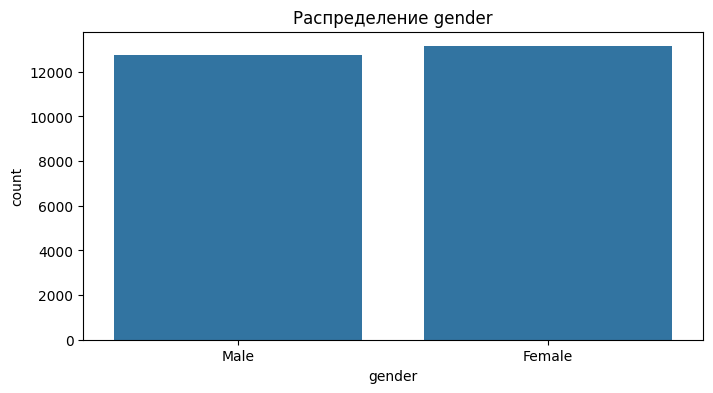

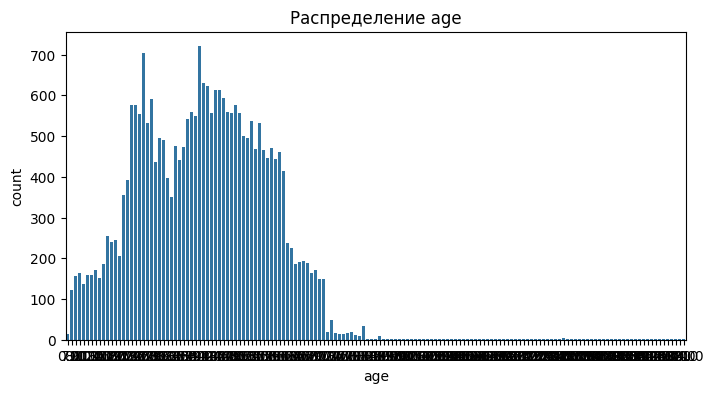

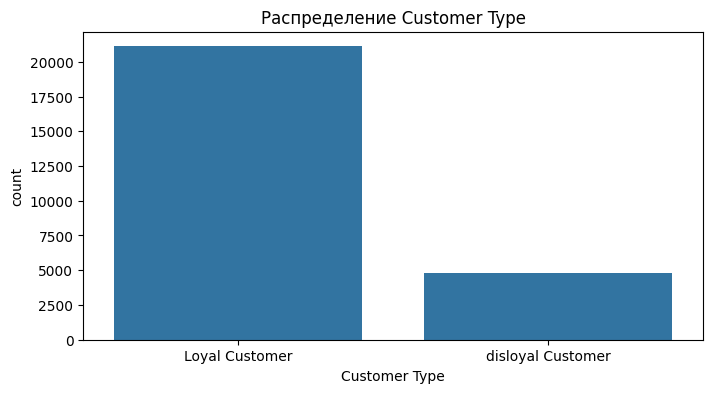

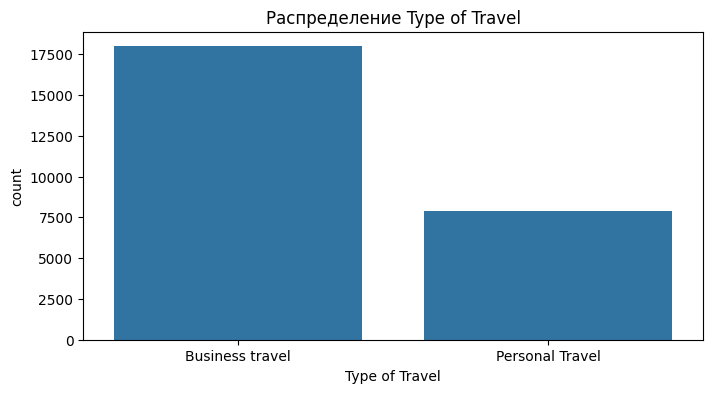

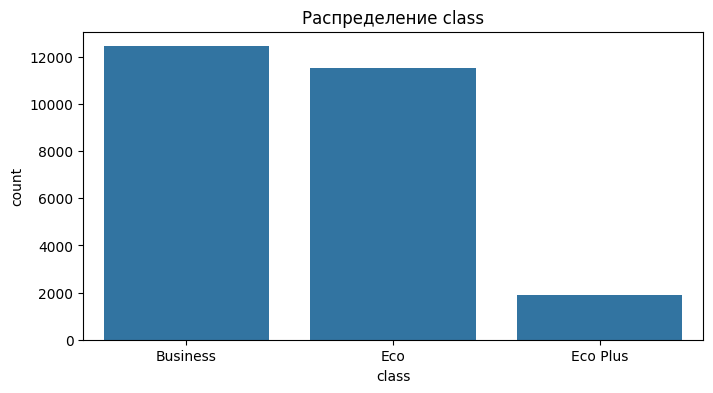

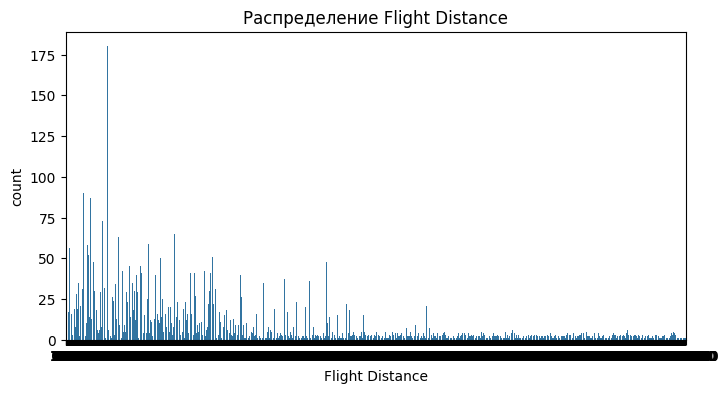

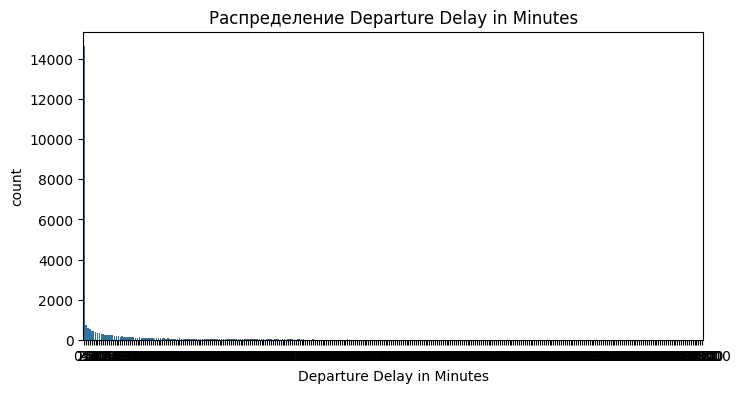

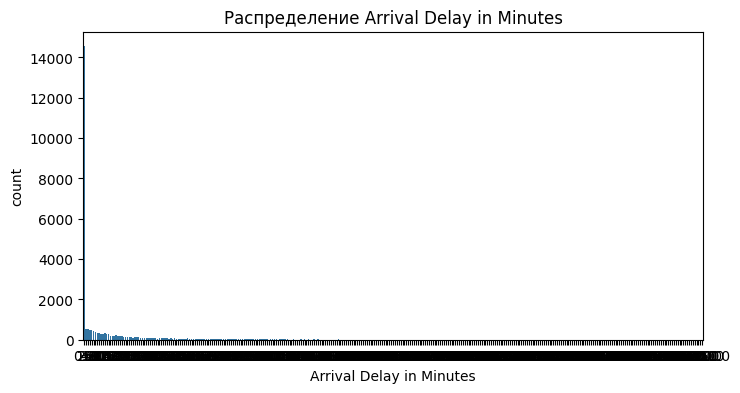

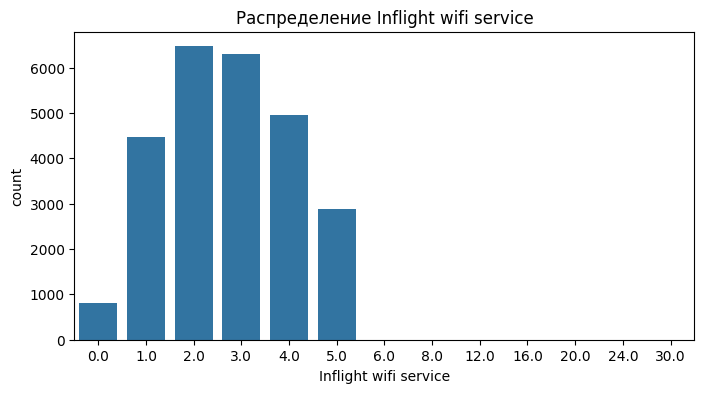

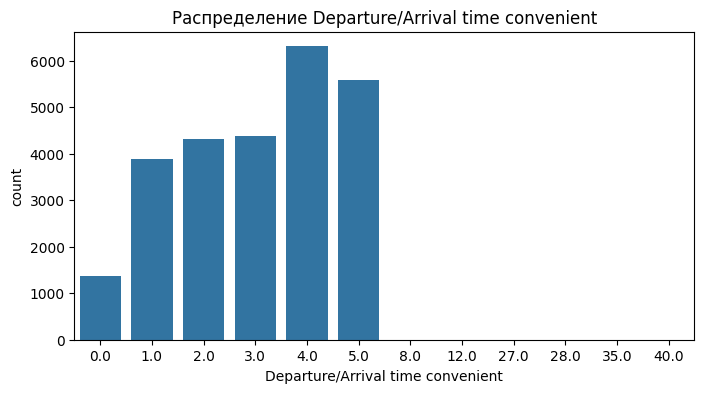

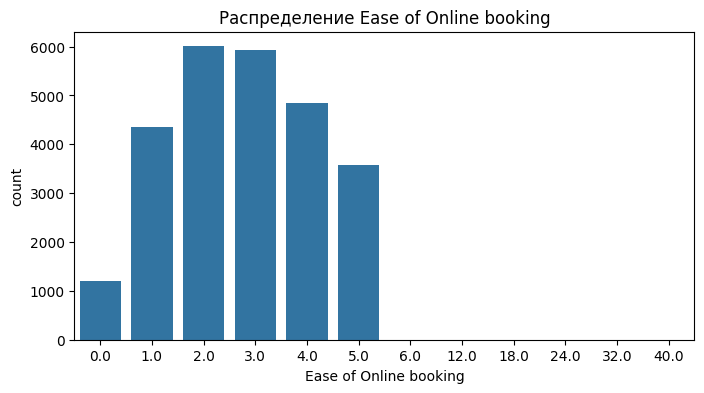

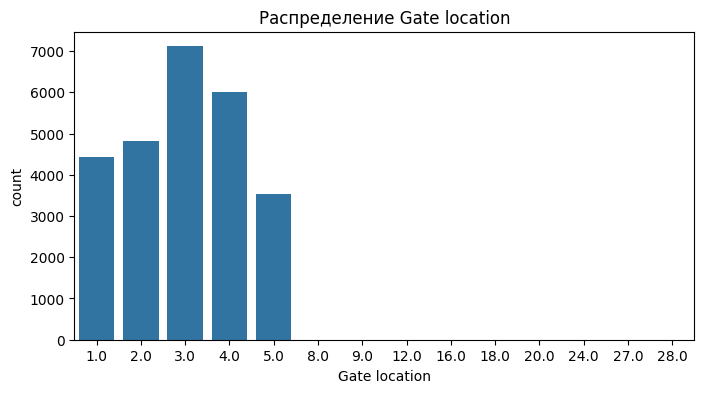

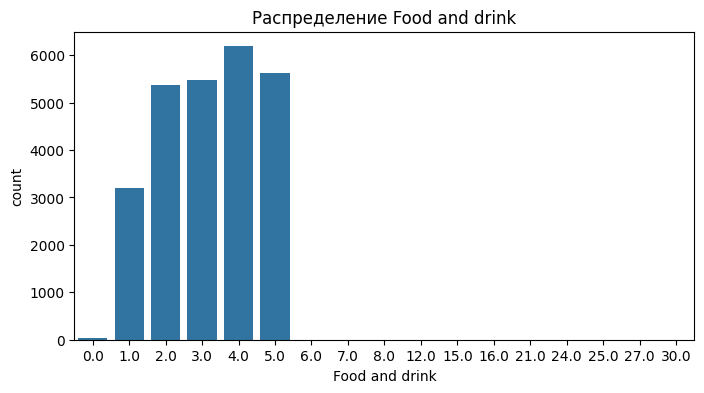

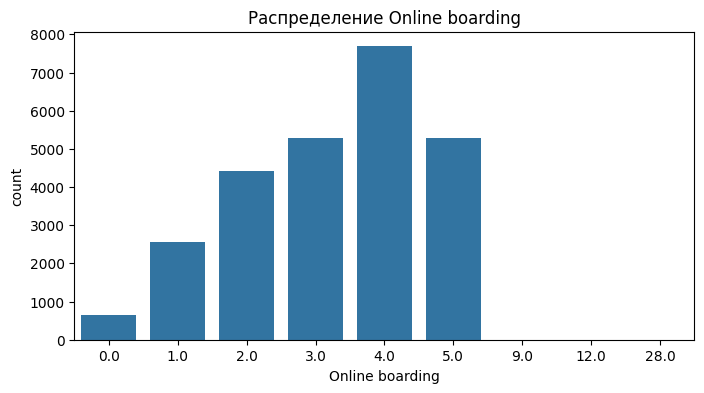

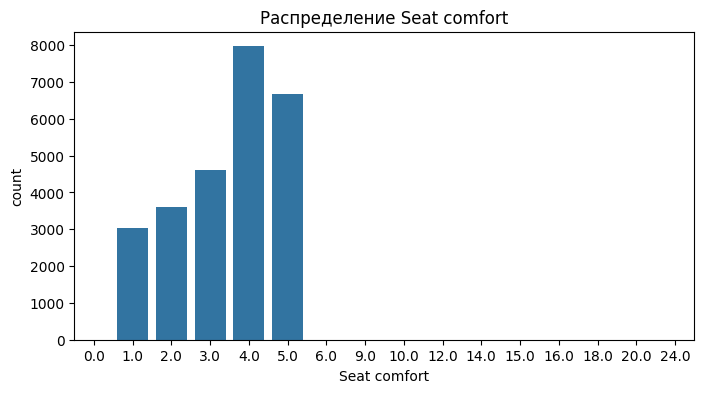

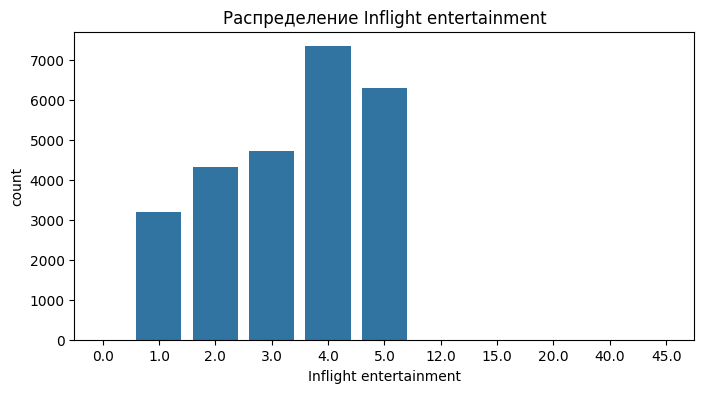

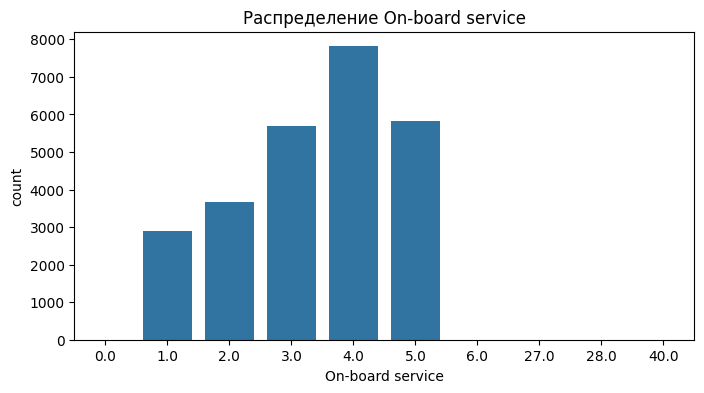

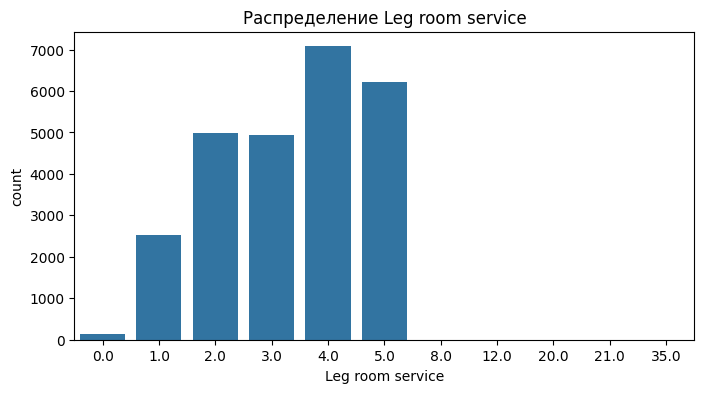

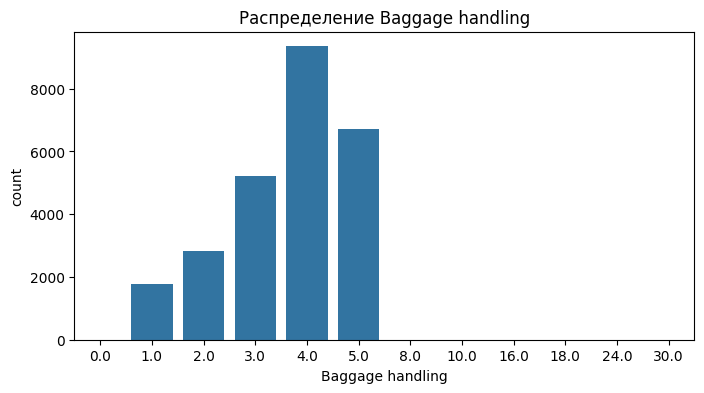

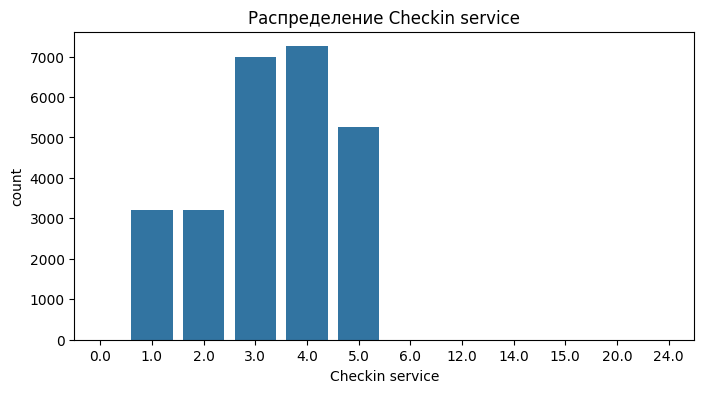

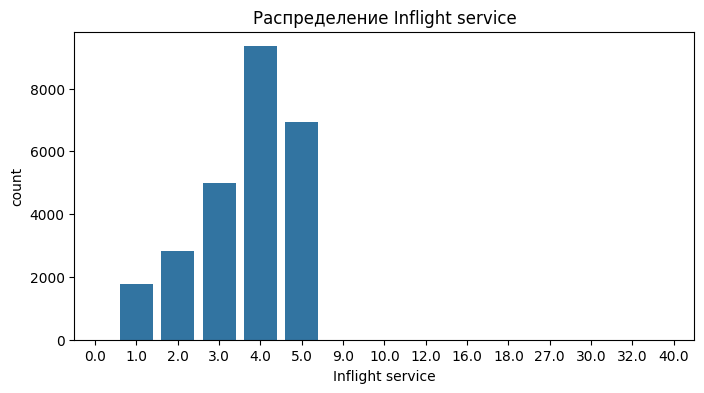

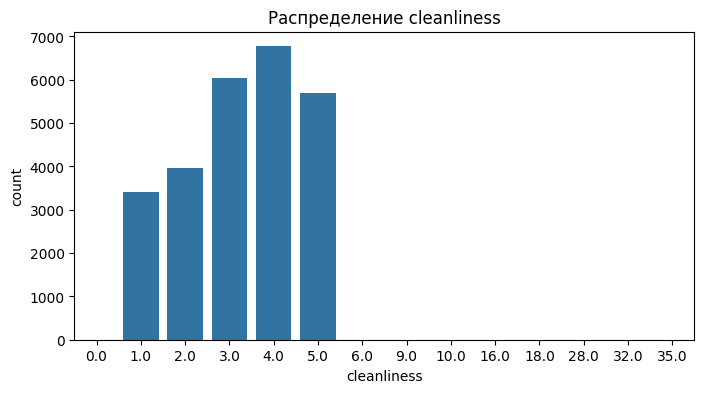

In [48]:
for col in df_test.columns:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.countplot(x=col, data=df_test, ax=ax)
    ax.set_title(f'Распределение {col}')
    plt.show()

Сразу можно сказать, что распределения в тестовой выборке имеют выбросы, также мы не имеем целевой переменной, что делает невозможным проанализировать разбиение по классам каждой переменной. Но, в целом, распределения признаков похожи на те, что исследовали в тренировочной выборке. В валидационной выборке переменные имеют одинаковое распределение, что и в тренировочной выборке.

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [49]:
X_train['Departure Delay in Minutes'] = np.log(X_train['Departure Delay in Minutes'] + 1)
X_train['Arrival Delay in Minutes'] = np.log(X_train['Arrival Delay in Minutes'] + 1)

X_val['Departure Delay in Minutes'] = np.log(X_val['Departure Delay in Minutes'] + 1)
X_val['Arrival Delay in Minutes'] = np.log(X_val['Arrival Delay in Minutes'] + 1)

Построение.

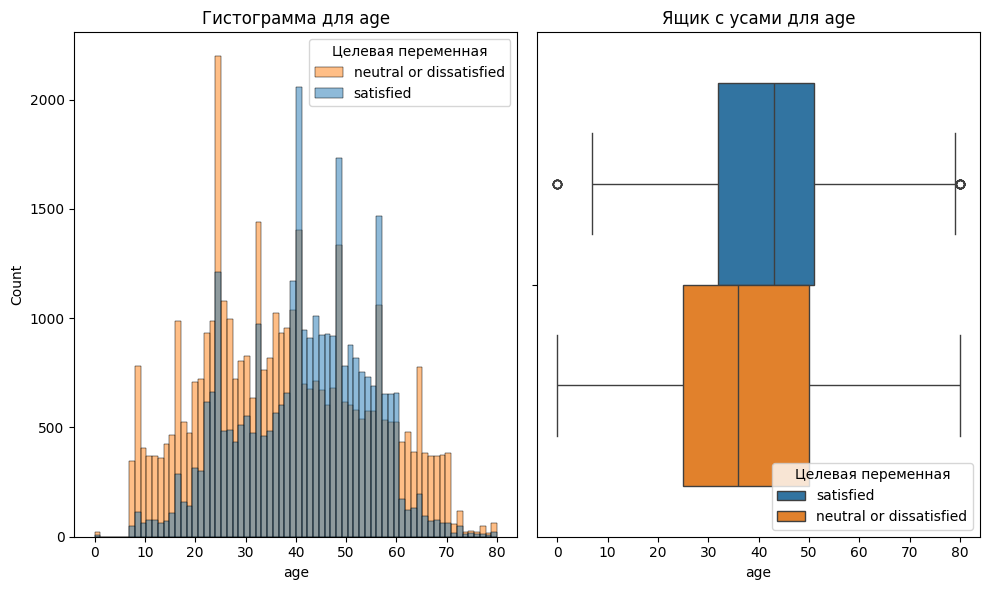

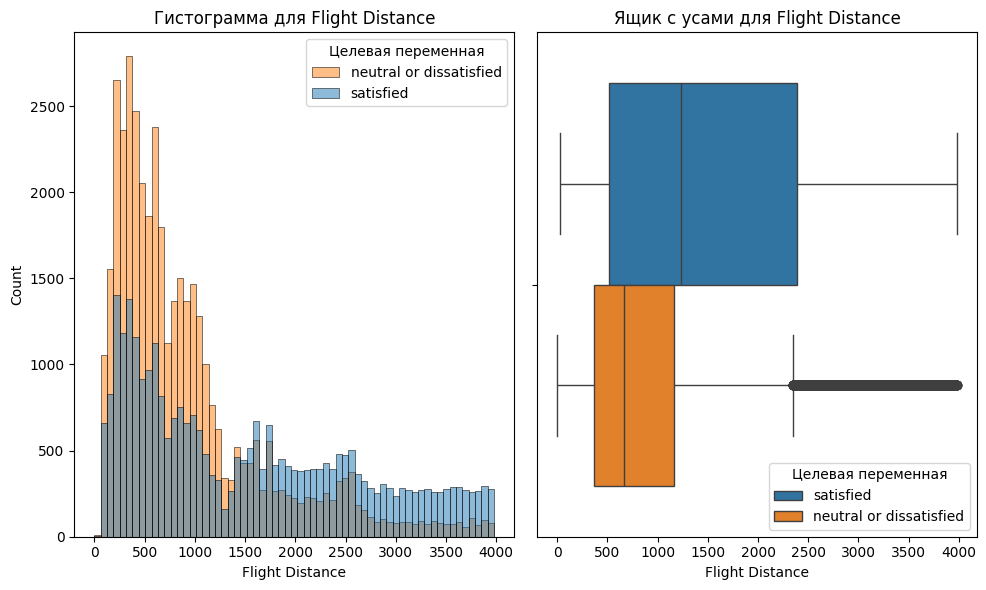

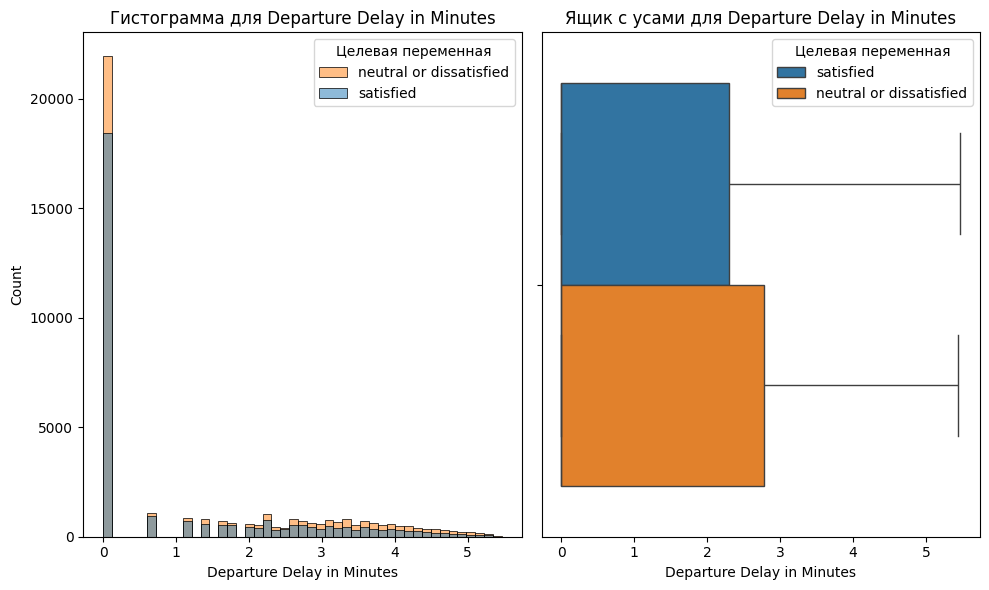

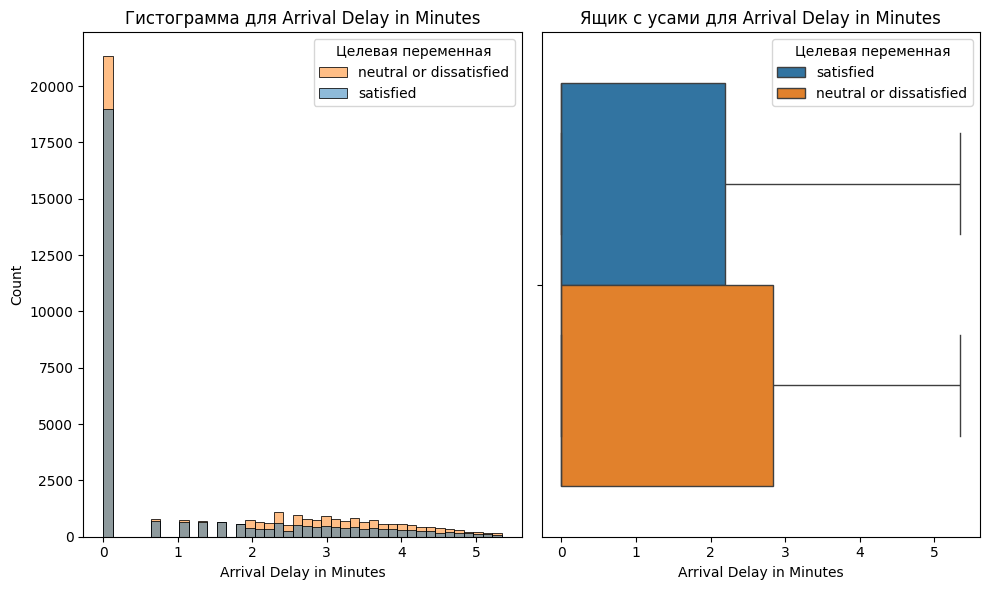

In [50]:
plot_continuous(continuous_cols, X_train, y_train)

После добавления логарифмической шкалы в двух признаках, где изначально было много объектов со значением 0 минут, мы получили более удобные графики для анализа и визуализации распределения.

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

In [51]:
X_train_scatterplot = X_train.copy()
X_train_scatterplot['target'] = y_train

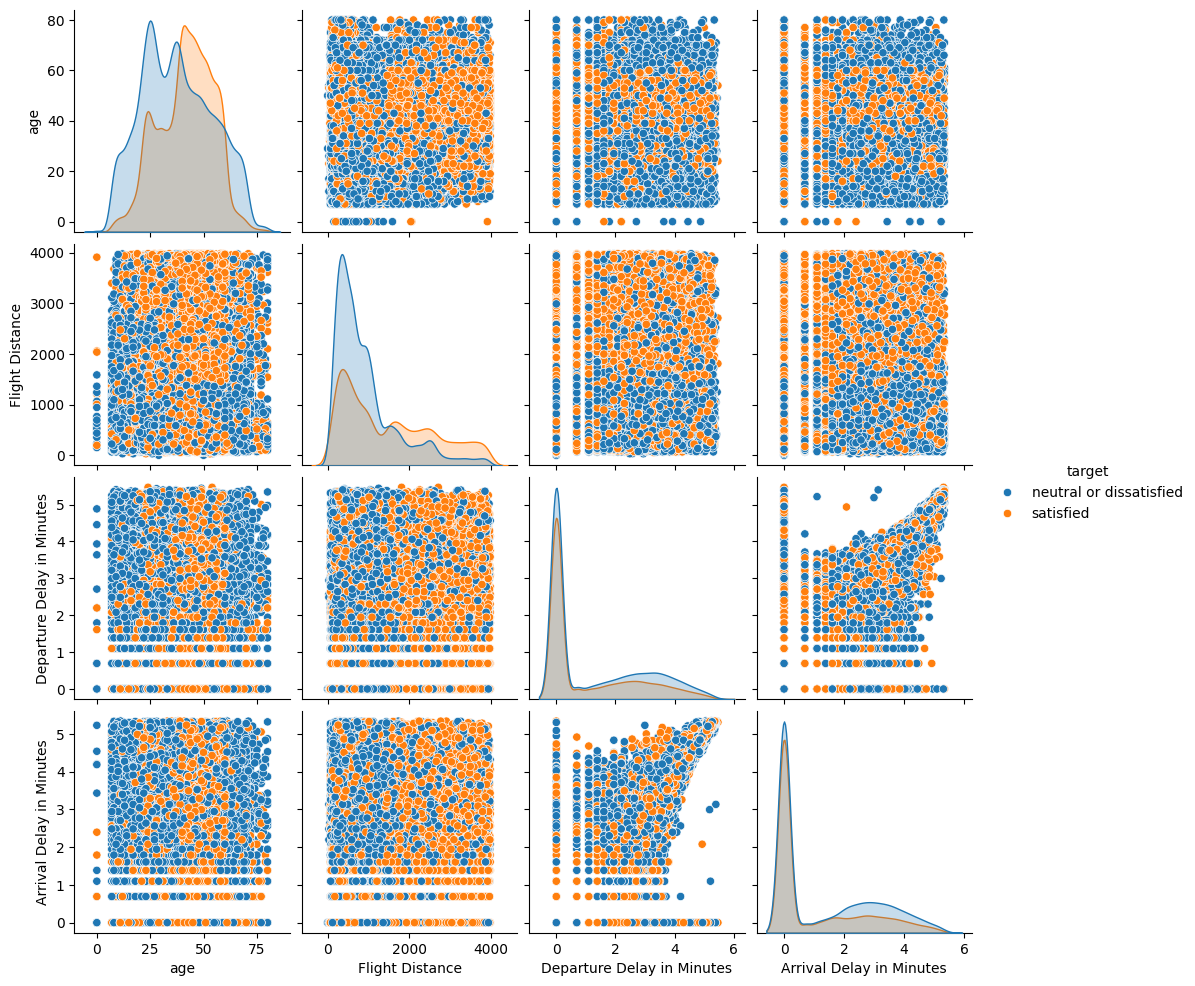

CPU times: user 1min 8s, sys: 872 ms, total: 1min 9s
Wall time: 1min 10s


In [52]:
%%time
sns.pairplot(data = X_train_scatterplot, hue='target', vars=continuous_cols)
plt.show()

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [53]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)


X_train = pd.get_dummies(X_train, columns=categorical_cols, dtype='int', drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, dtype='int', drop_first=True)

In [54]:
y_train = y_train[X_train.index]
y_val = y_val[X_val.index]

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [55]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_val)

val_accuracy = accuracy_score(y_val, dt_pred)
print(f"Accuracy (val): {val_accuracy}")

Accuracy (val): 0.9433733359564561


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [56]:
%%time
error_dt, bias_dt, var_dt = bias_variance_decomp(
    dt, X_train.values, y_train.values, X_val.values, y_val.values,
    loss='0-1_loss', random_seed=RANDOM_STATE
)

print(f'Error: {error_dt}')
print(f'Bias: {bias_dt}')
print(f'Variance: {var_dt}')

Error: 0.06185930224932783
Bias: 0.04046166961767985
Variance: 0.04595268542199489
CPU times: user 1min 47s, sys: 140 ms, total: 1min 47s
Wall time: 1min 48s


Модель действительно хорошая, мы видим, что смещение(bias) маленькое, но и разброс(variance) тоже небольшой.

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [57]:
depth = dt.get_depth()
leaves = dt.get_n_leaves()
print(f'Глубина дерева: {depth}')
print(f'Количество листьев: {leaves}')

Глубина дерева: 34
Количество листьев: 2019


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

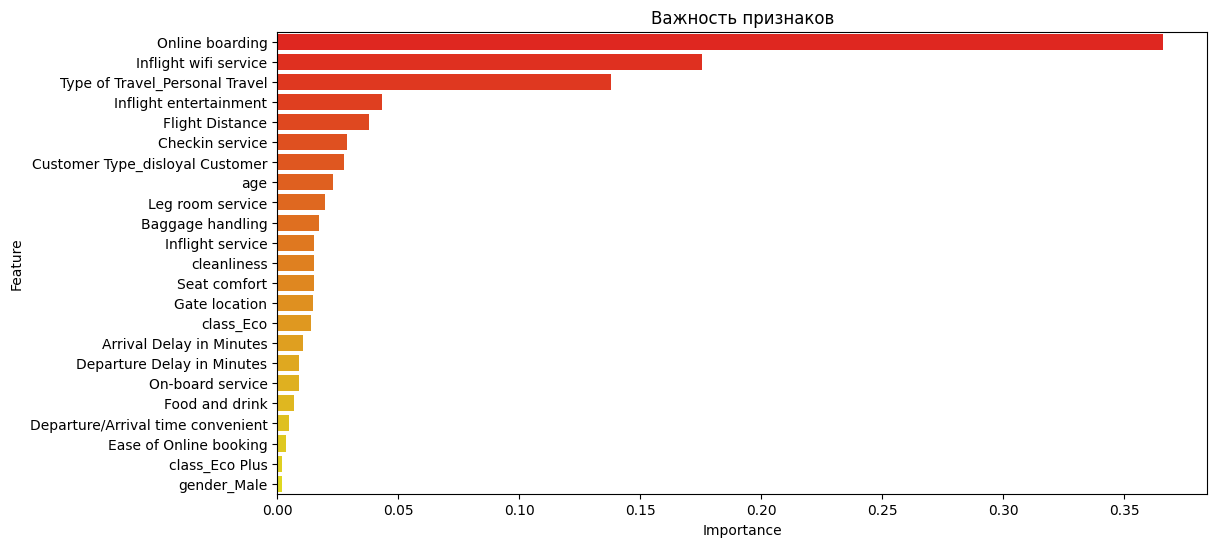

In [58]:
feature_importances = dt.feature_importances_

df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

df_feature_importance.sort_values(by='Importance', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df_feature_importance, x='Importance', y='Feature', hue='Feature', palette='autumn', legend=False, ax=ax)
ax.set_title(f'Важность признаков')
plt.show()

###`Информативные признаки:`

Наиболее информативными признаками оказались: `Online boarding`,`Inflight wifi service` и `Type of travel_personal Travel`.

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [59]:
col_selected = df_feature_importance[:2]['Feature'].tolist()
col_selected

['Online boarding', 'Inflight wifi service']

In [60]:
dt_limited = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
dt_limited.fit(X_train[col_selected], y_train)
dt_limited_pred = dt_limited.predict(X_val[col_selected])

val_accuracy = accuracy_score(y_val, dt_limited_pred)
print(f"Accuracy (val): {val_accuracy}")

Accuracy (val): 0.8251032854613417


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

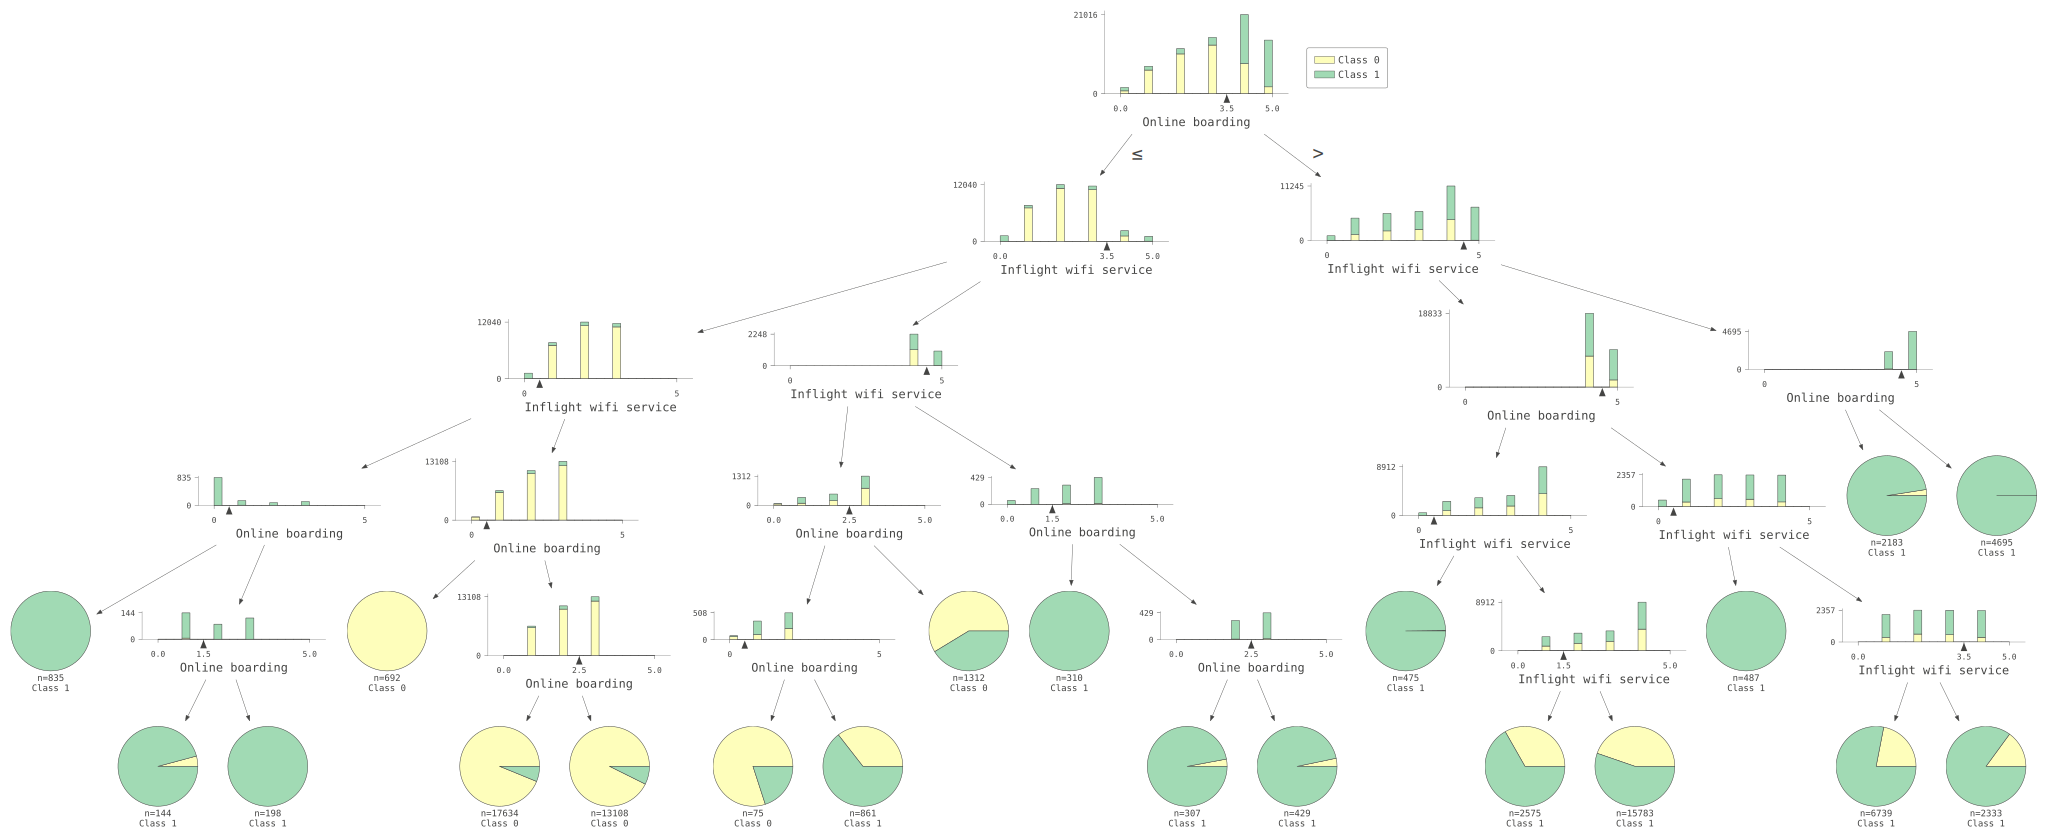

In [61]:
viz_model = dtreeviz.model(dt_limited, X_train[col_selected].values, y_train.values, feature_names=X_train[col_selected].columns.values)
viz_model.view(fontname="monospace", fancy = True, scale = 1.5)

In [62]:
X_train[col_selected]['Inflight wifi service'].value_counts()

Inflight wifi service
3.0    17733
2.0    17628
4.0    13493
1.0    12258
5.0     7924
0.0     2139
Name: count, dtype: int64

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

**Ответ:** Рассмторим количество оценок для каждой оценки в столбце `Inflight wifi service`. У нас 6 уникальных целых значений от 0 до 6. Не гугля предположу, что разделение дискретного множества значений идет ровно по середине, то есть в первом случае 3.5 - разделяющая граница двух классов: один >=3.5, а другой < 3.5. Алгоритму проще брать разделяющее значение ровно посередине от найденных классов.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

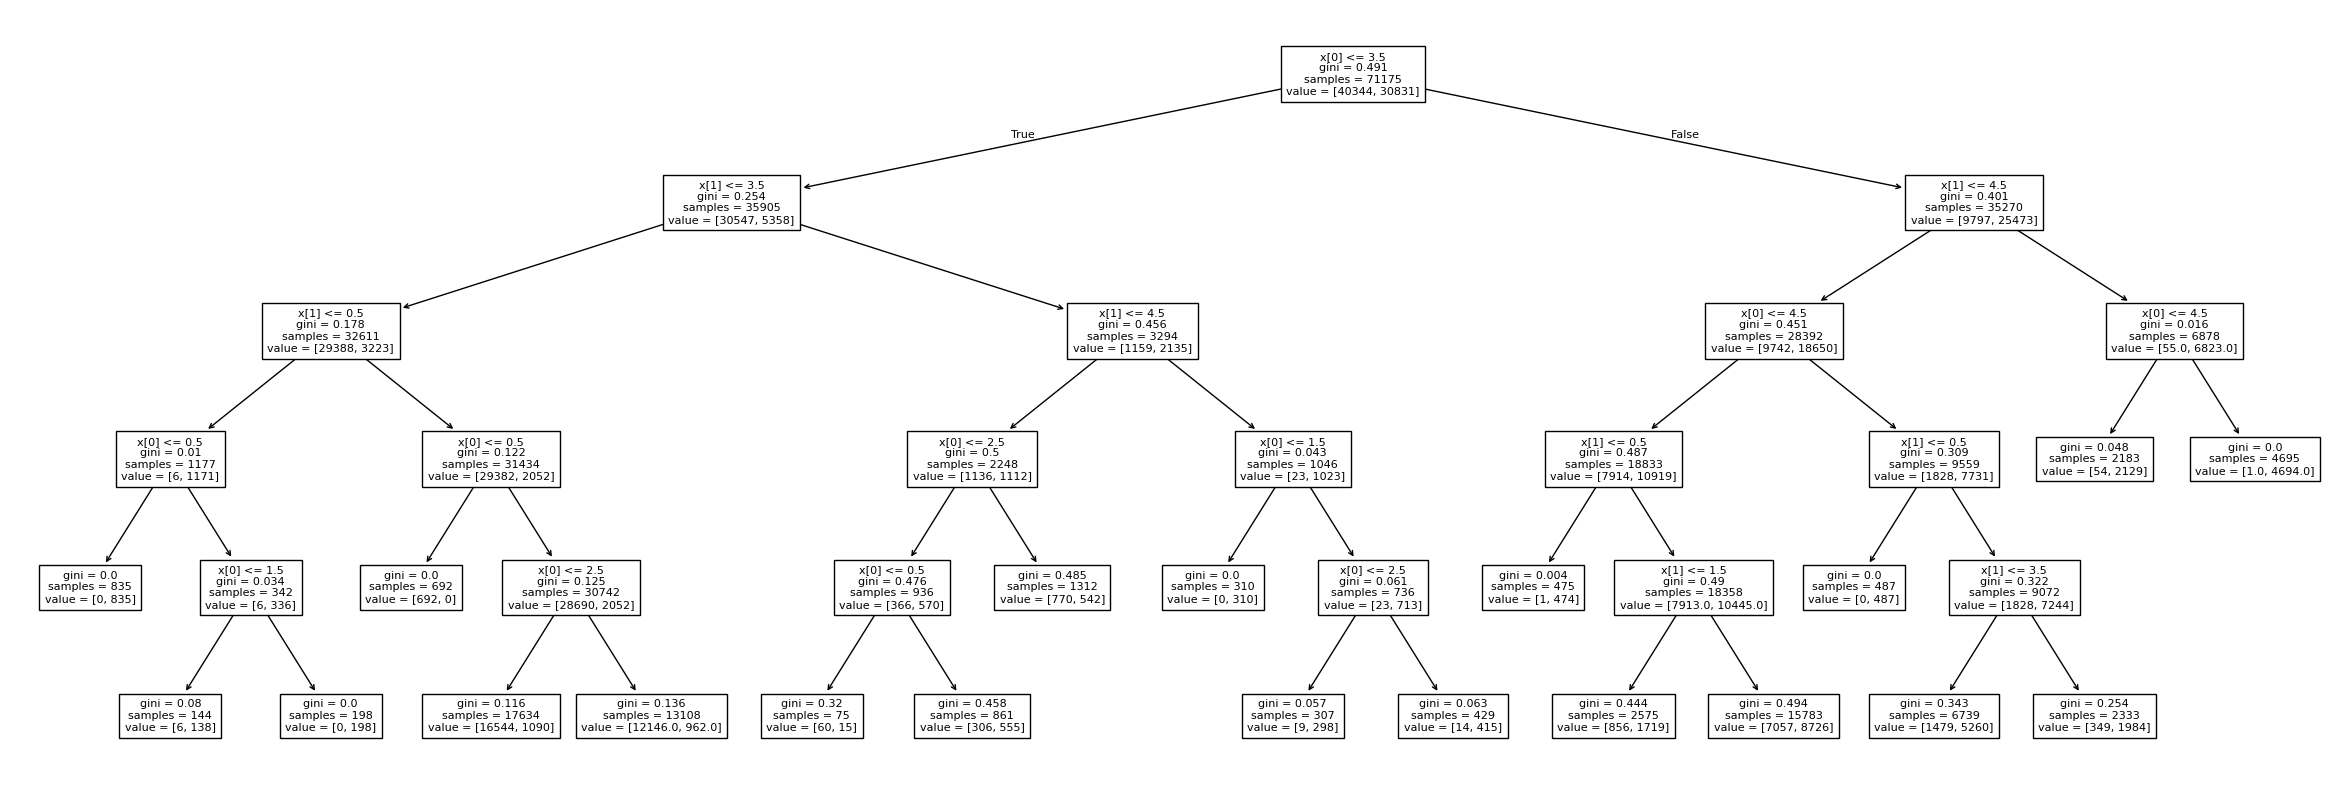

In [63]:
fig, ax = plt.subplots(figsize=(30,10))
plot_tree(dt_limited, ax=ax, fontsize=8)
plt.show()

Дерево получилось почти полностью симметричным, где-то не хватает листьев до полной симметрии. Симметричность - это хорошо, получилось сбалансированное дерево, ветви примерно одинаковой глубины, следовательно, мы не видим сильного переобучения, что хорошо. Например, одной из отличительных особенностей CatBoost является то, что в качестве базовых моделей используются симметричные деревья. Преимущество таких деревьев заключается в том, что это полные сбалансированные деревья с фиксированной структурой, а также что такие деревья удобно хранить в памяти компьютера.

Источник: stepik (Практический ML).

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

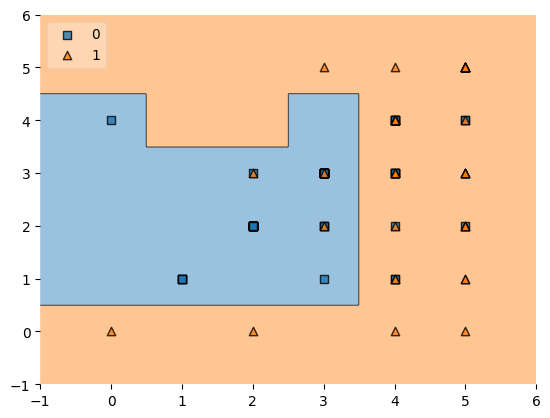

In [64]:
plot_decision_regions(X_train[col_selected].values[:100], y_train.values[:100], clf=dt_limited, legend=2)
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

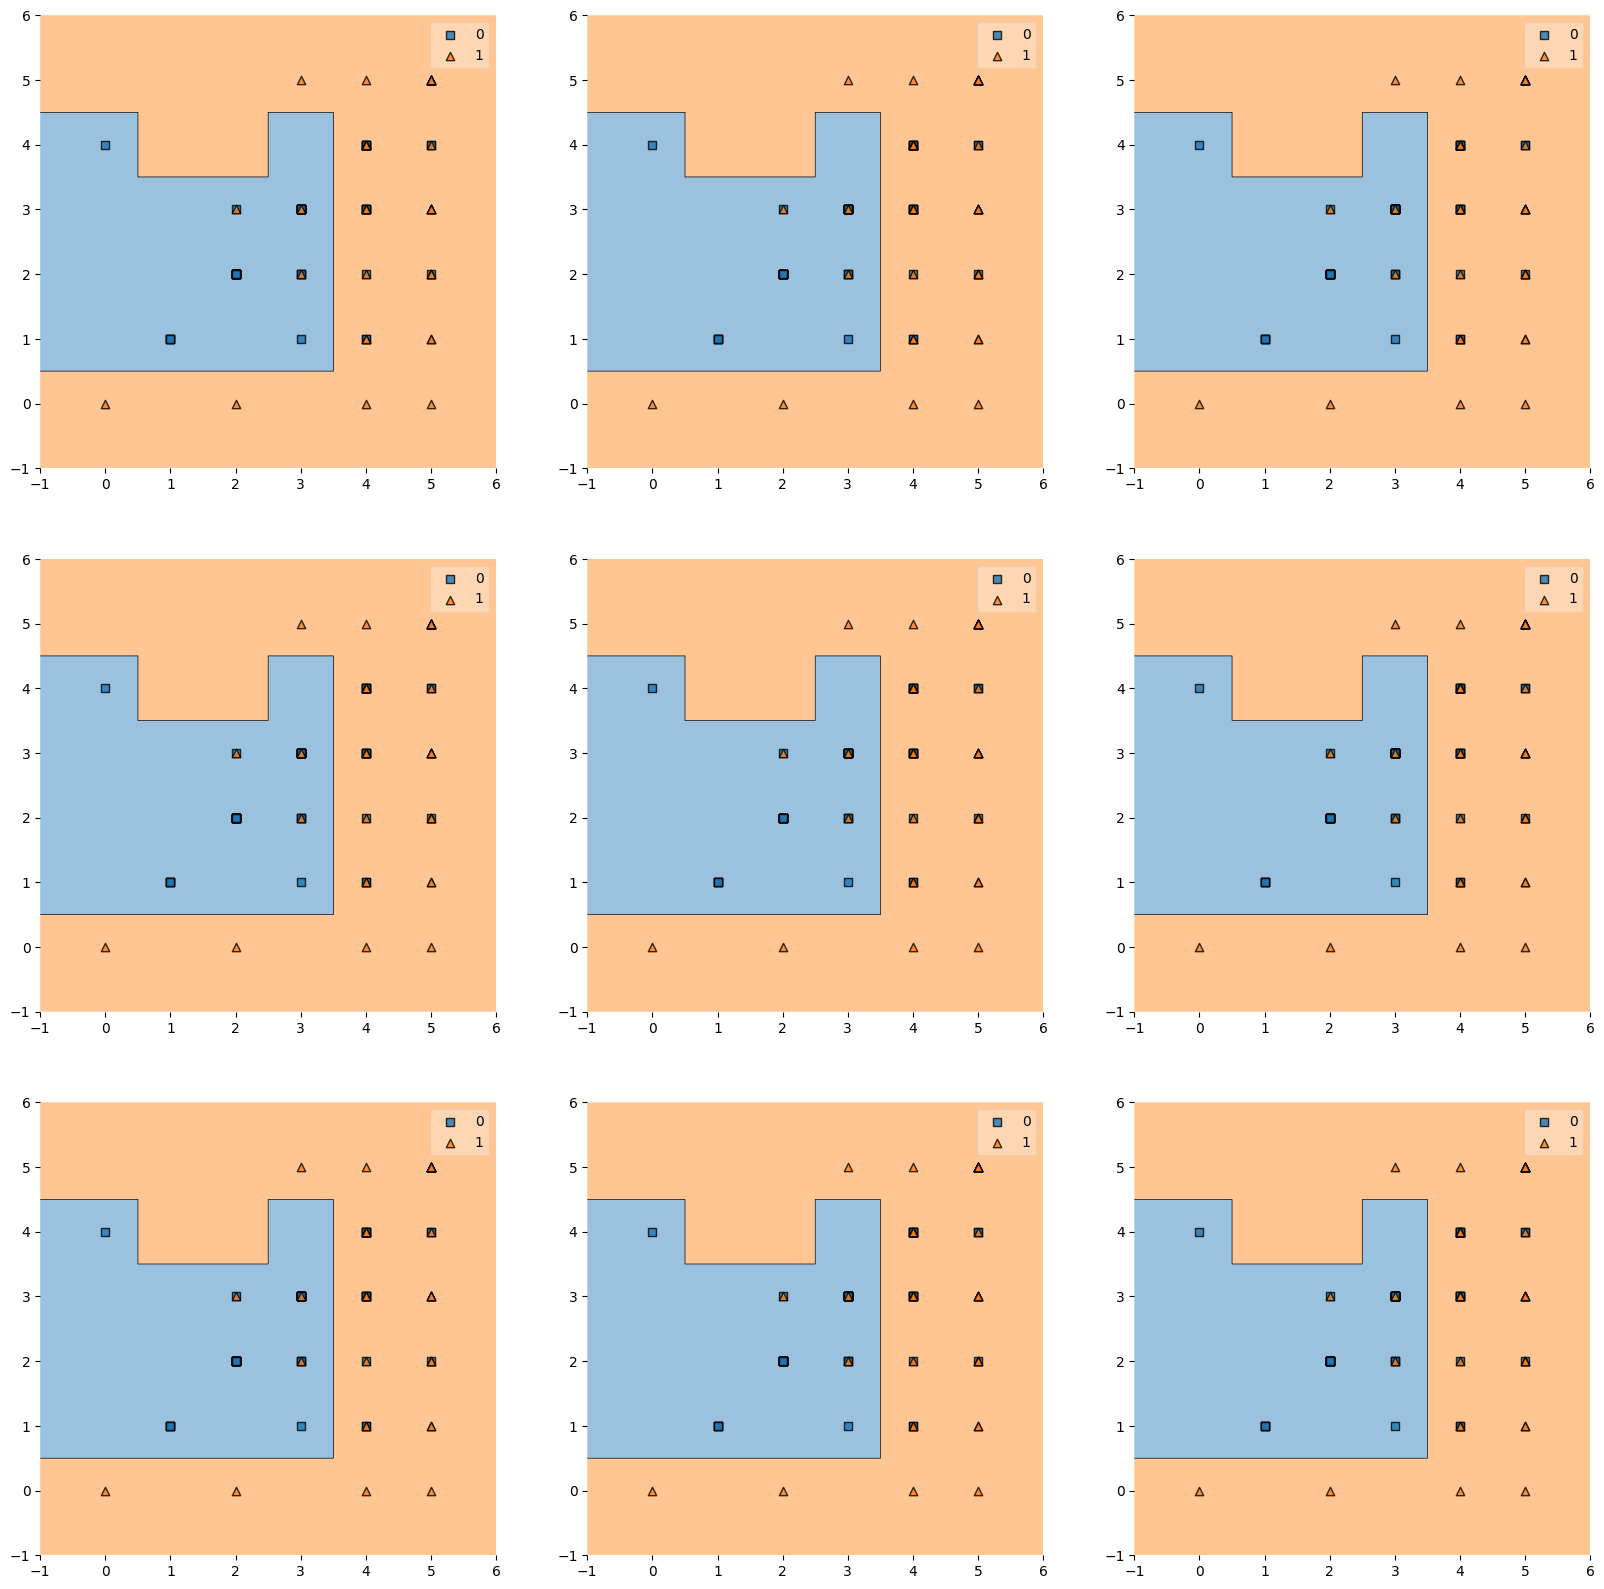

In [65]:
# замените X_train_example на вашу переменную

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train[col_selected].index, size=X_train[col_selected].shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train[col_selected].loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train[col_selected].iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [66]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.17 s, sys: 9.21 ms, total: 5.18 s
Wall time: 5.16 s


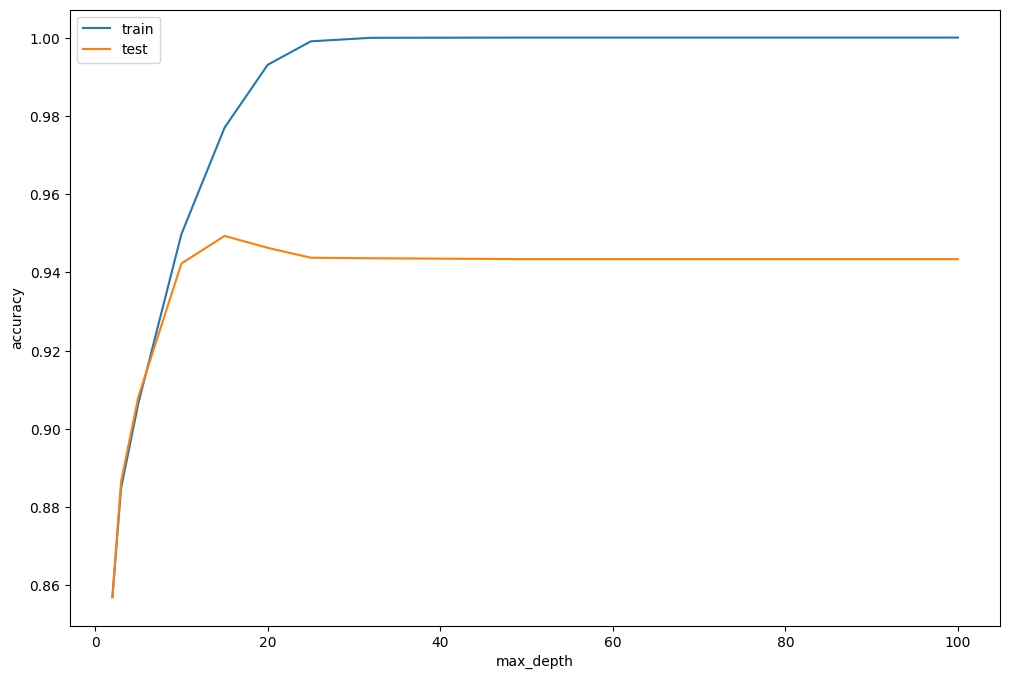

In [67]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [68]:
%%time
param_grid = {
    'max_depth': [None, 2, 4, 8, 12],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [2, 5, 8],
    'class_weight': ['balanced', None]
}

dt_best = DecisionTreeClassifier(random_state=RANDOM_STATE)
gs_dt_best = GridSearchCV(dt_best, param_grid, cv=5, scoring='accuracy')
gs_dt_best.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 147 ms, total: 1min 57s
Wall time: 1min 58s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 2, 4, 8, 12],
                         'min_samples_leaf': [2, 5, 8]},
             scoring='accuracy')

In [69]:
print("Лучшие гиперпараметры:", gs_dt_best.best_params_)

Лучшие гиперпараметры: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2}


In [70]:
dt_best = DecisionTreeClassifier(**gs_dt_best.best_params_, random_state=RANDOM_STATE)
dt_best.fit(X_train, y_train)
dt_best_pred = dt_best.predict(X_val)

val_accuracy = accuracy_score(y_val, dt_best_pred)
print(f"Accuracy (val): {val_accuracy}")

Accuracy (val): 0.9488163158239885


Да, удалось немного улучшить качество предсказаний подбором гиперпараметров.

Accuracy на валидационной выборке:
- с гиперпараметрами по умолчанию: 0.9433733359564561
- с подобранными гиперпараметрами: 0.9488163158239885

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [71]:
with open('DT.pkl', 'wb') as f:
    pickle.dump(dt_best, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [72]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

val_accuracy = accuracy_score(y_val, rf_pred)
print(f"Accuracy (val): {val_accuracy}")

Accuracy (val): 0.9609810479375697


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

In [73]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

clf_list = [
    (rf, "RandomForest")
]

In [74]:
def display_calibrated_curve(clf_list, X_train, y_train, X_val, y_val):
    fig, ax_calibration_curve = plt.subplots(figsize=(12, 6))
    colors = plt.cm.get_cmap("Dark2")

    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        display = CalibrationDisplay.from_estimator(
            clf,
            X_val,
            y_val,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(f"Calibration plot ({name})")
    plt.show()

    return calibration_displays

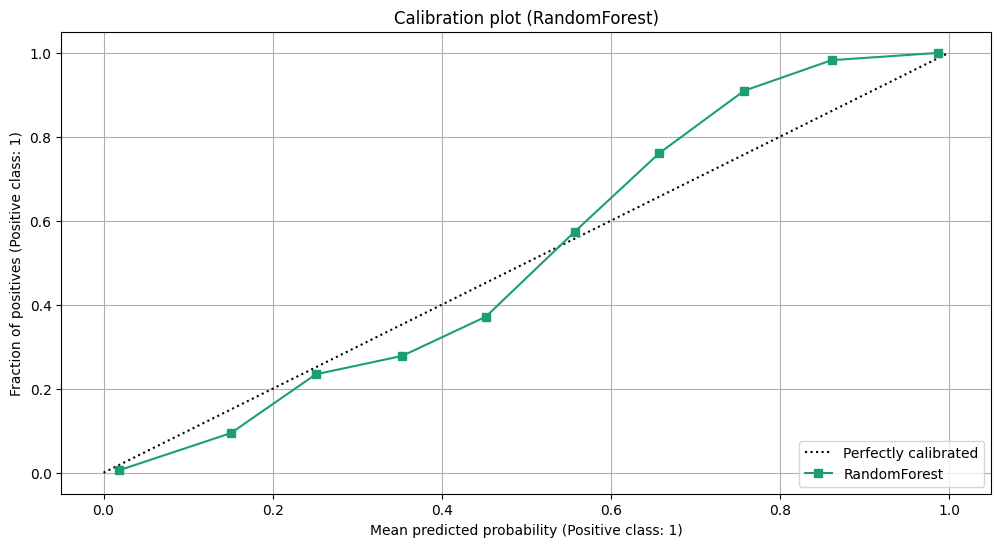

In [75]:
cal_disp_rf = display_calibrated_curve(clf_list, X_train, y_train, X_val, y_val)

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



####```Ответ:```

Нет, деревья не совсем корректно предсказывают вероятности:
- деревья фактически не имеют прямой вероятностной интерпретации (в классическом смысле) — они, как правило, назначают класс на основе большинства примеров в листьях (вероятность для класса можно интерпретировать как долю положительных примеров в данном листе)
- деревья не всегда корректно предсказывают вероятности (особенно если классы несбалансированы)
- деревья склонны к переобучению
- для улучшения прогноза часто используют дополнительное калибровочное преобразование (Платта и т.д.)

Источники:
- чат по дз4
- Stepik(модуль 10)
- https://habr.com/ru/companies/otus/articles/502200/


### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [76]:
log_reg = LogisticRegression(random_state=RANDOM_STATE)
log_reg.fit(X_train, y_train)
y_prob = log_reg.predict(X_val)

val_accuracy = accuracy_score(y_val, y_prob)
print(f'Accuracy (val): {val_accuracy}')

Accuracy (val): 0.8431700439373073


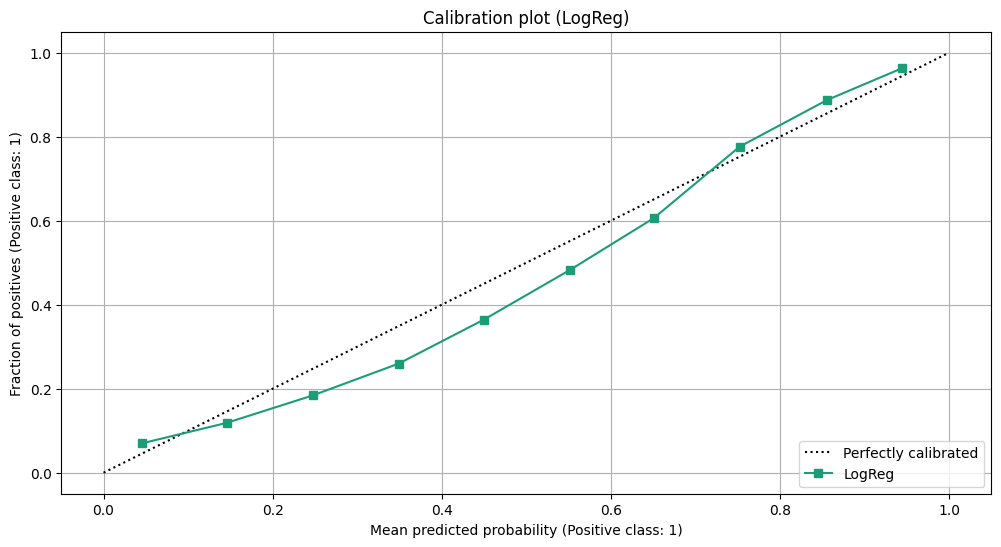

In [77]:
clf_list.append((log_reg, "LogReg"))
cal_disp_lr = display_calibrated_curve([clf_list[1]], X_train, y_train, X_val, y_val)

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

####```Ответ:```
Логистическая регрессия не всегда корректно определяет вероятности, но стремится к этому. Например, если данных недостаточно, тогда алгоритм обучается плохо. Или когда логистическая регрессия не справляется с задачей, которая не является линейно разделимой, а логистическая регрессия использует линейный подход. В таких случаях, если логистическая регрессия решает задачу неправильно, то и вероятности будут некорректными.

Но, как пишут в хендбуке по ML, давайте "попробуем понять и простить" логистическую регрессию, и вот почему:
- Логрег использует сигмоиду, эта функция принимает любое значение x и выдает значение в интервале [0; 1], таким образом, такие выходные значения могут быть интерпретированы как вероятность принадлежности к одному из классов;
- Минимизирует логарифмическую функцию потерь. Логистическая регрессия для оптимизации использует метод максимизации правдоподобия. Это приводит к минимизации логарифмической функции потерь (кросс-энтропии), делая вероятности более точными, тем самым согласуя предсказанные вероятности с истинными метками классов;
- В основе логрега лежит предположение о том, что данные следуют логистическому распределению. Это обеспечивает согласованность предсказанных вероятностей с реальными данными.

Источники:
- Хендбук по машинному обучения от Яндекса, параграф 2.1 и 4.4 (https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)
- чат по дз4 и лекция 13 по калибровке вероятностей

### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [78]:
rf_sigmoid = CalibratedClassifierCV(rf, cv=3, method="sigmoid")
rf_isotonic = CalibratedClassifierCV(rf, cv=3, method="isotonic")

In [79]:
clf_list.append((rf_sigmoid, "RandomForest + Sigmoid"))
clf_list.append((rf_isotonic, "RandomForest + Isotonic"))

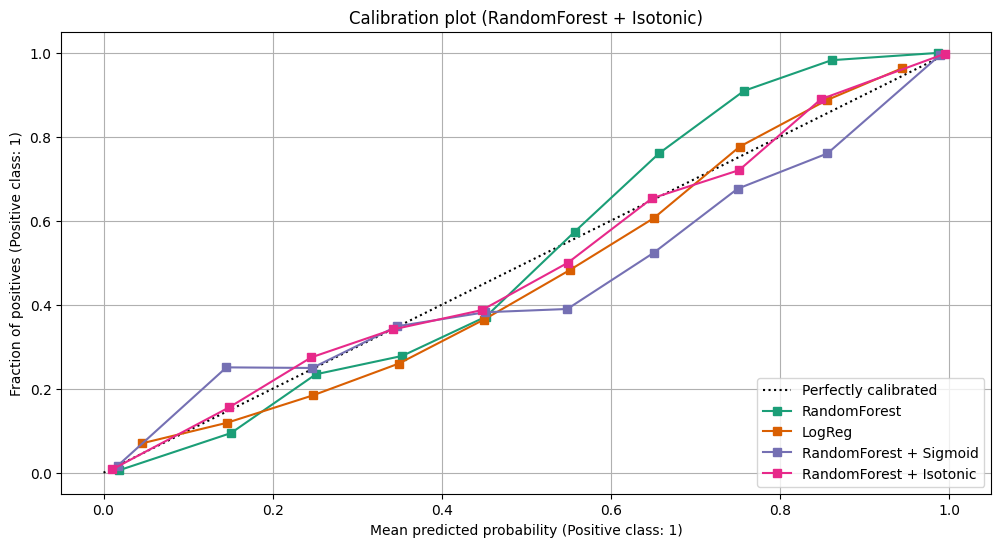

In [80]:
cal_disp_all = display_calibrated_curve(clf_list, X_train, y_train, X_val, y_val)

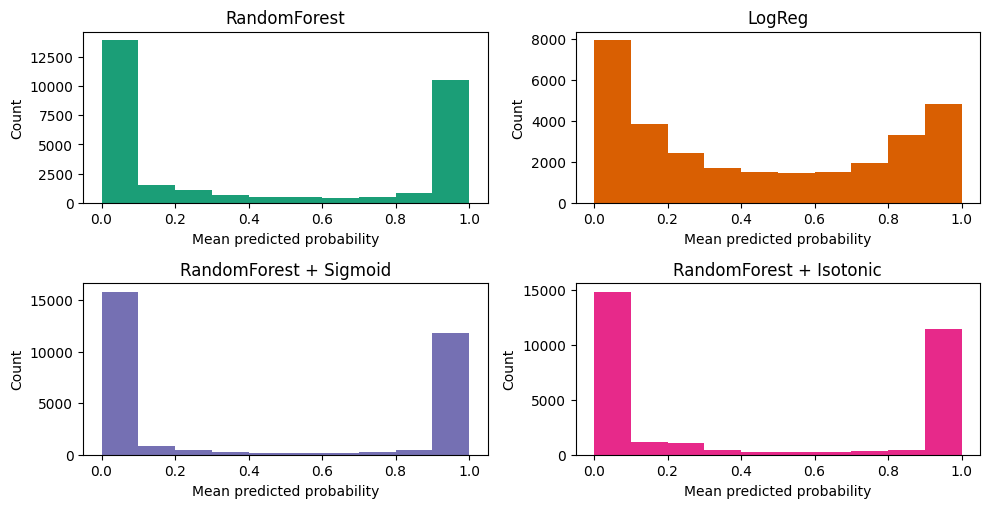

In [81]:
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        cal_disp_all[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

На графике калибровочных кривых отображены 4 кривые: для случайного леса, логистической регрессии, логрег+случайный лес и изотоническая регрессия. Нашу модель случайного леса можно классифицировать по ее виду как неуверенный классификатор. Видно, что вероятности у случайного леса не откалиброваны, это особенно заметно при средней предсказанной вероятности >0.5, то есть это означает, что мы предсказываем класс 1 менее уверенно, чем могли бы. Такое может случиться, например, если мы слишком много обращаем внимания на трудные для классификации объекты на границе классов, в каком-то смысле в ущерб более однозначно определяемым точкам. Этим же могут и грешить модели на основе бэггинга, такие как случайный лес. Грубо говоря, среднее нескольких моделей предскажет что-то близкое к единице только если все слагаемые предскажут что-то, близкое к единице — но из-за дисперсии моделей это будет случаться реже, чем могло бы. Сама по себе логистическая регрессия находится достаточно близко к идеально откалиброванной кривой, а вот сигмоидальная регрессия зеркально поменяла проблемы с вероятностями случайного леса. Изотоническая регрессия, напротив, прекрасно приближает вероятности к логрегу и, соответственно, к идеальной калибровочной кривой.

Источники:
- Хендбук по машинному обучения от Яндекса, параграф 4.4 (https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)
- лекция и материалы к лекции 13 по калибровке вероятностей

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

####``` Методы калибровки вероятностей ```

####**1. Гистограммная калибровка.**
Модель предсказывает вероятности на объектах, которые мы упорядочиваем. Далее разбиваем область прогнозов на фиксированные бины - кусочки равные по длине или равномощные (в каждом отрезке одинаковое количество объектов). Берем вероятности внутри кажого бина и усредняем.

####**2. Изотоническая регрессия.**
Улучшенная гистограмная калибровка, где сами бины - тоже параметры модели.
Обучаем на прогнозах модели(вероятности, которые модель спрогнозировала) калибровочную функцию, так чтобы прогнозы стали близки к правильным ответам. Таким образом, мы обучаем еще и границы бинов и, соотвественно, средние значения вероятностей. Поэтому у изотонической регрессии больше параметров, что позволяет ей быть ближе к диагонали - идеальной калибровочной кривой. Алгоритм обучения изотонической регрессии сложен для объяснения, но суть его заключается в следующем: точки на графике, представляющие предсказанные упорядоченные вероятности, должны лежать на монотонно неубывающей кривой. Поэтому, когда мы сталкиваемся с новым значением другой вероятности, которое меньше предыдущего предсказания, мы итеративно усредняем значения, пока не получим монотонно неубывающую кривую. Визуализацию можно посмотреть по третьей ссылке.

####**3.Калибровка Платта**
Поверх прогнозов модели применяем логистическую регрессию в надежде на то, что логрег, которая лучше предсказывает вероятности, попроавит наши прогнозы. Но следует помнить, что если изначально прогноз был плохой, то данная калибровка может не помочь.

####**4. И так далее))**
Другие методы можно посмотреть по второй ссылке.

####**Источники:**
- Хендбук по машинному обучения от Яндекса, параграф 4.4 (https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)
- https://alexanderdyakonov.wordpress.com/2020/03/27/проблема-калибровки-уверенности/
- https://josephsalmon.eu/blog/isotonic/
- лекция 13 по калибровке вероятностей


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [82]:
%%time
error_rf, bias_rf, var_rf = bias_variance_decomp(
    rf, X_train.values, y_train.values, X_val.values, y_val.values,
    loss='0-1_loss', random_seed=RANDOM_STATE
)

print(f'Error: {error_rf}')
print(f'Bias: {bias_rf}')
print(f'Variance: {var_rf}')

Error: 0.040764968194635716
Bias: 0.03924847530985638
Variance: 0.009038297593284807
CPU times: user 30min 49s, sys: 1.98 s, total: 30min 51s
Wall time: 31min 9s


####```Ответ: ```

Bias-Variance-Decomp для DecisionTree:
- Error: 0.06185930224932783
- Bias: 0.04046166961767985
- Variance: 0.04595268542199489

Тогда мы сделали вывод, что модель действительно хорошая, мы видим, что смещение(bias) маленькое, но и разброс(variance) тоже небольшой.

Bias-Variance-Decomp для RandomForest:
- Error: 0.040764968194635716
- Bias: 0.03924847530985638
- Variance: 0.009038297593284807

Разложение ошибки случайного леса показывает, что сама ошибка и смещение уменьшились, а также разброс модели существенно снизился. Это ожидаемо, поскольку случайный лес - это композиция из нескольких деревьев, построенная таким образом, чтобы при сохранении качества предсказания целевой переменной (сохранение смещения) как можно сильнее уменьшить переобучение (разброс) по сравнению с одним решающим деревом.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [83]:
%%time
error_lr, bias_lr, var_lr = bias_variance_decomp(
    log_reg, X_train.values, y_train.values, X_val.values, y_val.values,
    loss='0-1_loss', random_seed=RANDOM_STATE
)

print(f'Error: {error_lr}')
print(f'Bias: {bias_lr}')
print(f'Variance: {var_lr}')

Error: 0.15560266246967014
Bias: 0.15351826349268805
Variance: 0.02162108990753492
CPU times: user 4min 39s, sys: 2min 9s, total: 6min 48s
Wall time: 3min 53s


Вычисленное разложение ошибки для логистической модели показывает, что применение логрега для решение данной задачи не самый лучший выбор.
Смещение составляет ~ 0.16, что довольно высокое значение. Это означает, что модель имеет значительное систематическое отклонение от истинных значений, то есть выбранная модель слишком простая и не учитывает важные особенности данных. Дисперсия относительно низкая - около 0.02. Это хороший показатель, так как низкая дисперсия указывает на то, что модель достаточно стабильна и не подвержена значительному переобучению. Таким образом, мы получили ожидаемые результаты. Действительно, логистическая регрессия в данной задачи - слишком простая линейная модель, которая стабильно показывает средние относительно древесных алгоритмов результаты.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [84]:
rf_params = {
    'max_samples': uniform(0.1, 0.9),

    'n_estimators': randint(100, 500),
    'max_depth': randint(1, 15),
    'min_samples_leaf': randint(2, 30),
    'criterion': ['gini', 'entropy', 'log_loss']
}


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=25,
    cv=4,
    verbose=4,
    random_state=RANDOM_STATE
)

In [85]:
%%time
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV 1/4] END criterion=log_loss, max_depth=4, max_samples=0.9556428757689246, min_samples_leaf=12, n_estimators=171;, score=0.905 total time=   4.2s
[CV 2/4] END criterion=log_loss, max_depth=4, max_samples=0.9556428757689246, min_samples_leaf=12, n_estimators=171;, score=0.911 total time=   4.2s
[CV 3/4] END criterion=log_loss, max_depth=4, max_samples=0.9556428757689246, min_samples_leaf=12, n_estimators=171;, score=0.910 total time=   5.0s
[CV 4/4] END criterion=log_loss, max_depth=4, max_samples=0.9556428757689246, min_samples_leaf=12, n_estimators=171;, score=0.908 total time=   4.2s
[CV 1/4] END criterion=gini, max_depth=5, max_samples=0.24041677639819287, min_samples_leaf=20, n_estimators=314;, score=0.916 total time=   5.5s
[CV 2/4] END criterion=gini, max_depth=5, max_samples=0.24041677639819287, min_samples_leaf=20, n_estimators=314;, score=0.919 total time=   5.0s
[CV 3/4] END criterion=gini, max_depth=5, max_samp

In [86]:
print('Лучшие гиперпараметры: ', random_search.best_params_)
rf_pred_rs = best_rf.predict(X_val)
val_score = accuracy_score(y_val, rf_pred_rs)
print(f'Accuracy (val):, {val_score}')

Лучшие гиперпараметры:  {'criterion': 'entropy', 'max_depth': 14, 'max_samples': 0.5680612190600297, 'min_samples_leaf': 11, 'n_estimators': 359}
Accuracy (val):, 0.9485212145058692


In [87]:
best_rf = rf

После подбора гиперпараметров качество модели упало, так что оставляем RandomForest с гиперпараметрами по умолчанию в качестве лучшей модели случайного леса((

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [88]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

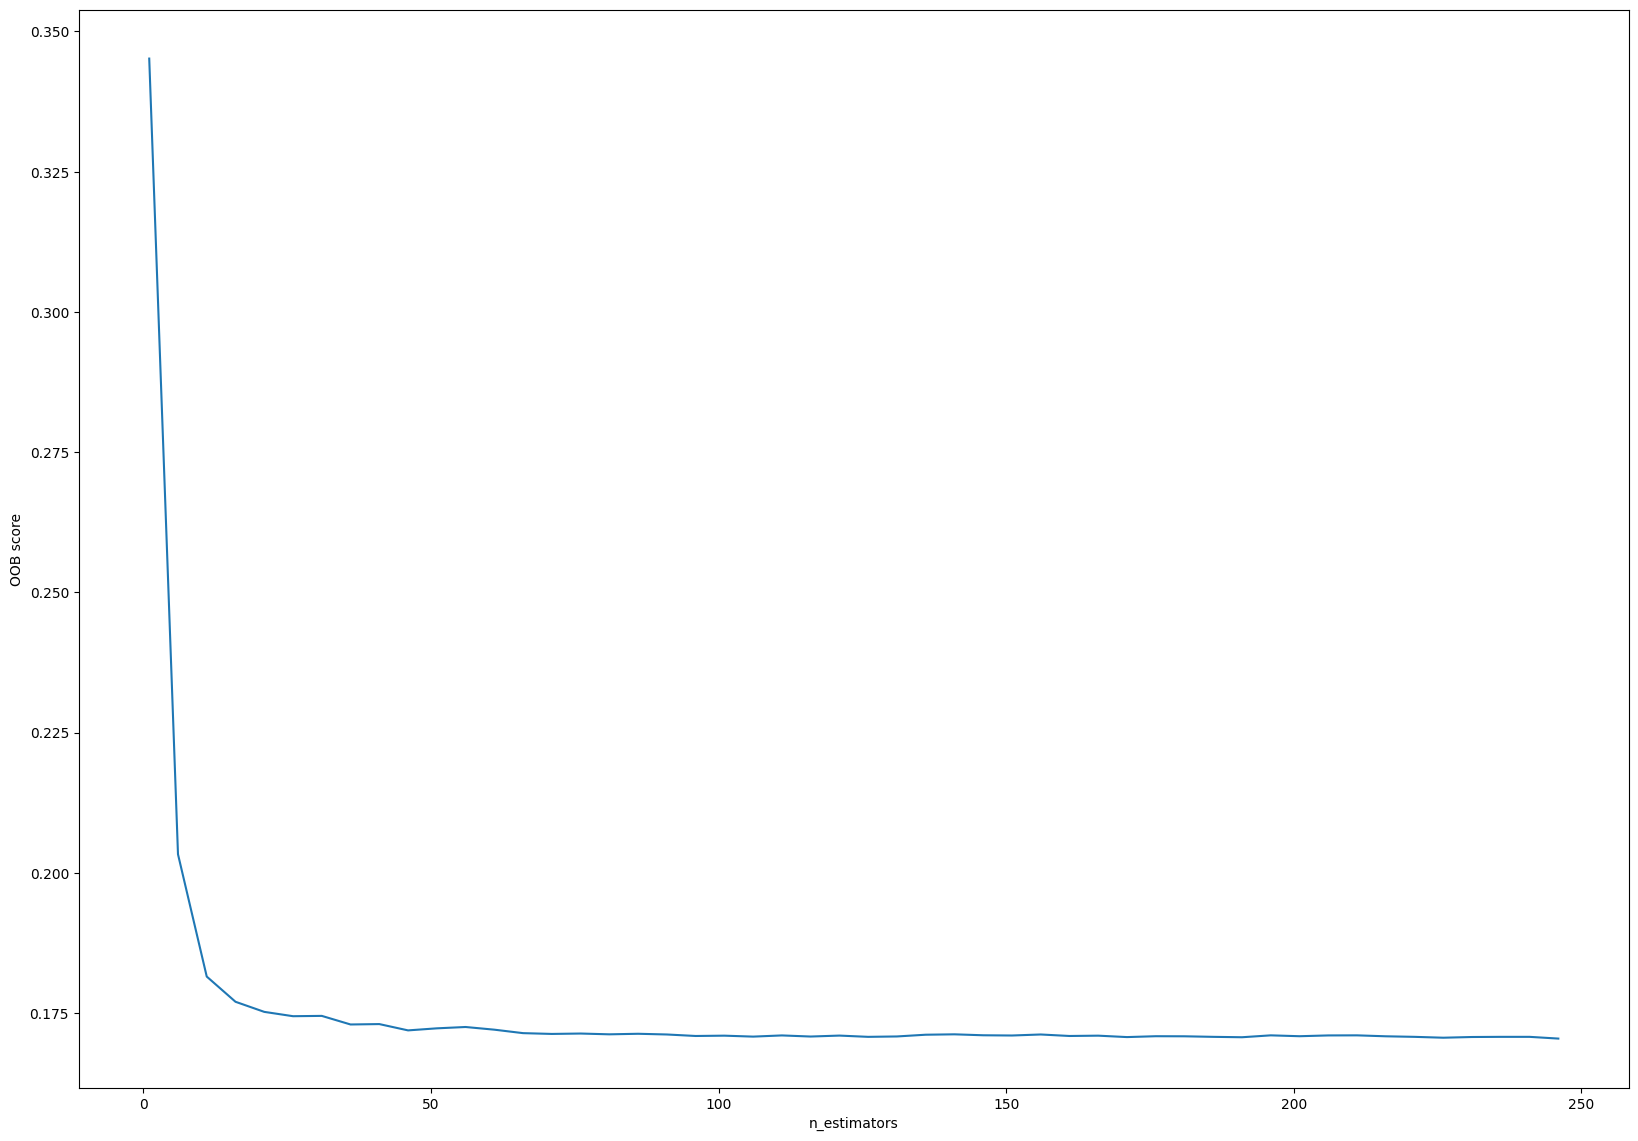

In [89]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


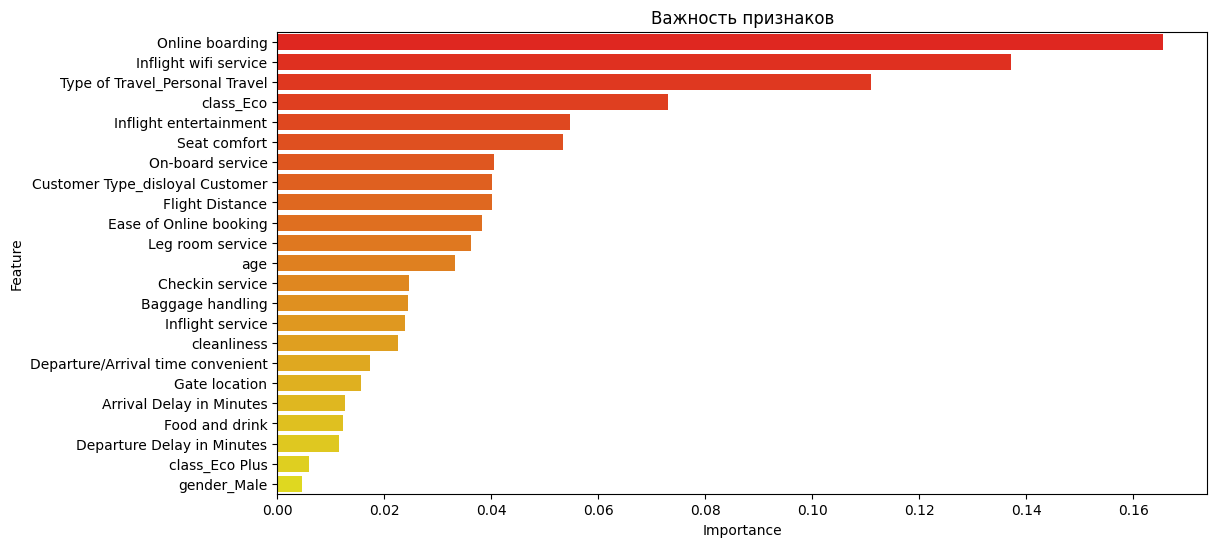

In [90]:
feature_importances_best_rf = best_rf.feature_importances_

best_rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_best_rf
})

best_rf_feature_importance.sort_values(by='Importance', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=best_rf_feature_importance, x='Importance', y='Feature', hue='Feature', palette='autumn', legend=False, ax=ax)
ax.set_title(f'Важность признаков')
plt.show()

In [91]:
best_rf_feature_importance.head()

Feature  Importance
9                  Online boarding    0.165569
4            Inflight wifi service    0.137186
20  Type of Travel_Personal Travel    0.111000
21                       class_Eco    0.073124
11          Inflight entertainment    0.054808

In [92]:
topk = 7
print(f"Топ-{topk} важных признаков для DecisionTree:\n{', '.join(df_feature_importance.Feature.tolist()[:topk])}\n")
print(f"Топ-{topk} важных признаков для RandomForest:\n{', '.join(best_rf_feature_importance.Feature.tolist()[:topk])}")

Топ-7 важных признаков для DecisionTree:
Online boarding, Inflight wifi service, Type of Travel_Personal Travel, Inflight entertainment, Flight Distance, Checkin service, Customer Type_disloyal Customer

Топ-7 важных признаков для RandomForest:
Online boarding, Inflight wifi service, Type of Travel_Personal Travel, class_Eco, Inflight entertainment, Seat comfort, On-board service


Первые 7 наиболее значимые признаки показывают, что для `DecisionTree` и `RandomForest` одними из наиболее важных признаков являются `Online boarding`, `Inflight wifi service`, `Type of Travel_Personal Travel` и `Inflight entertainment`.

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [100]:
with open('RF.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

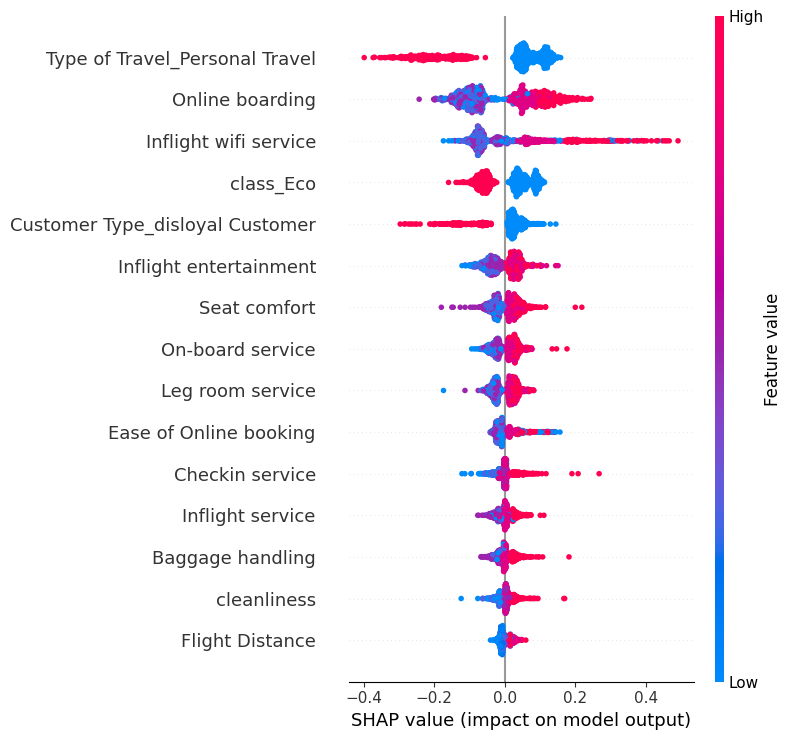

CPU times: user 6min 2s, sys: 1.66 s, total: 6min 3s
Wall time: 6min 3s


In [94]:
%%time
tree_explainer = shap.TreeExplainer(best_rf)
shap_values_tree = tree_explainer.shap_values(X_val[:1000])
shap.summary_plot(shap_values_tree[:,:,1], X_val[:1000], max_display=15)

`Ответ:` Гистограмма важности признаков показывает важность признаков, а именно, их значение Шепли по всем объектам выборки. В данной гистограмме признаки уже отсортированны по важности.

На графике также отображена следующая информация:

- Impact: позиция точки по горизонтали показывает как влияет значение признака на более высокий или более низкий прогноз (более высокий прогноз - точка правее, более низкий - левее)
- Original value: цвет показывает значение признака (красный - большие значения признака, синий - маленькие)
- Correlation: рассмотрим признак `Inflight WiFi Service`, то есть услуга Wi-Fi во время полета. Это оценка услуги во время полета, которую поставил путешественник. Высокий уровень этой оценки имеет в основном высокое и положительное влияние на удовлетворенность полетом в целом (целевая переменная). Таким образом, "высокий" отображается красным цветом, а "положительное" влияние показано на оси Х. Аналогично, мы можем сказать, что `Type of Travel_Personal Travel` имеет отрицательную корреляцию с целевой переменной.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

In [95]:
%%time
explainer_waterfall = shap.Explainer(best_rf)
shap_values_waterfall = explainer_waterfall(X_val[:1000])

CPU times: user 5min 59s, sys: 1.6 s, total: 6min 1s
Wall time: 6min


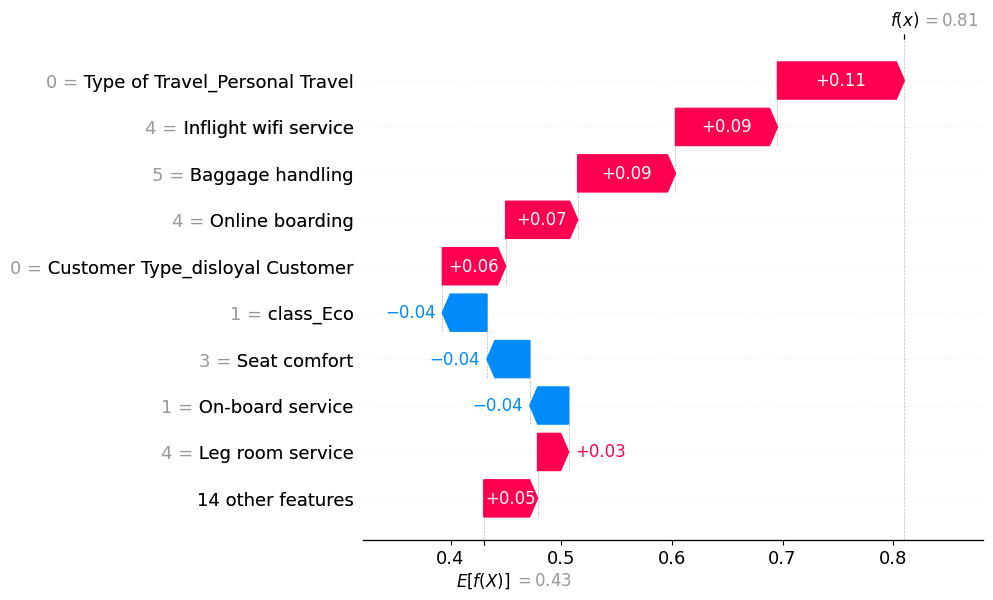

In [96]:
id_to_explain = 32
output_to_explain = 1
shap.plots.waterfall(shap_values_waterfall[id_to_explain, :, output_to_explain])

`Waterfall plot` показывает предсказание на 32 тестовом(валидационном) примере(можно выбрать любой пример из данных). SHAP values получены с помощью метода Tree SHAP. Схема читается снизу вверх, и признаки упорядочены по возрастанию их SHAP values. Например, SHAP value -0.04 для признака `Seat comfort` (имеющего значение 3) говорит о том, что значение `Seat comfort`= 3 на данном примере уменьшает величину предсказания модели, по сравнению с отсутствием признака `Seat comfort`, при произвольном наличии других признаков.

In [97]:
shap.initjs()
id_to_explain = 512
expected_value_tree = tree_explainer.expected_value
shap.force_plot(tree_explainer.expected_value[0], shap_values_tree[id_to_explain, :7, 1], X_val.iloc[id_to_explain, :7])

Значение Шепли для индивидуального объекта с индексом 512. Значение сверху - значение прогноза (0.56). Базовое значение(base value): в оригинальной статье про значения Шепли объясняется, что базовое значение E(yhat) - это "значение,
которое было бы предсказано, если бы мы не знали никаких признаков для текущего вывода". Другими словами, это среднее предсказание, или mean(yhat). Для Ytest в данном случае среднее равно 0.57. Вклад каждого признака обозначен стрелками снизу. Красные признаки увеличивают прогноз вправо, а синие признаки отрицательно влияют на целевую переменную.

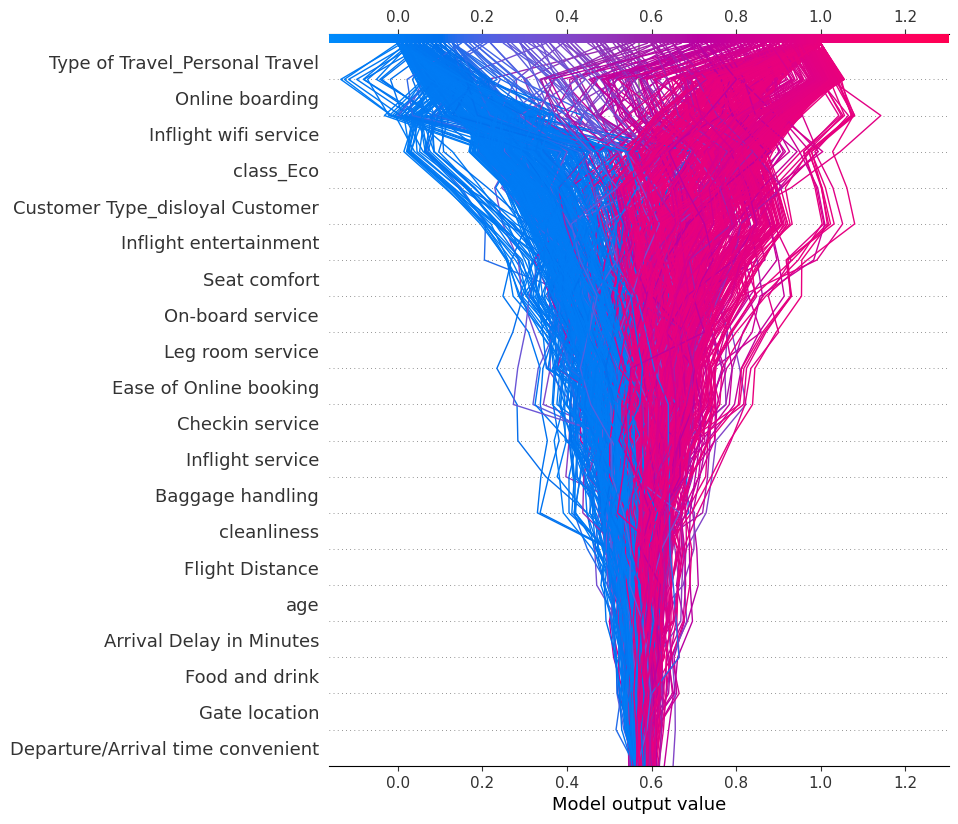

In [98]:
expected_value = tree_explainer.expected_value
shap.decision_plot(expected_value[0], shap_values_tree[:, :, 0], X_val[:1000])

Еще один график, который показывает важность признаков и их влияние на предсказания модели. Значения SHAP, положительные и отрицательные, отображаются на горизонтальной оси, которая показывает их влияние на предсказание. Линия на графике - предсказания для конкретного образца, которые отклоняется от среднего значения в результате воздействия каждого признака. Позиция точки на оси SHAP показывает, как сильно и в какую сторону (положительное или отрицательное влияние) каждый признак влияет на итоговое предсказание.

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

Так как Lime работает с вероятностями, а не предсказаниями для классификатора, то запустим нашу лучшую модель случайного леса с predict_proba.

In [99]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_val.values, feature_names=X_val.columns.values.tolist(), mode='classification')
explanation_lime = explainer_lime.explain_instance(X_val.values[500], best_rf.predict_proba, num_features=10)

explanation_lime.show_in_notebook(show_table=True)

`Описание графика:`
- Слева - прогноз модели. Предсказание на данном объекте (удовлетворенность клиента) - клиент удовлетворен полетом (с вероятностью 84%)
- Посередине график с наиболее важными для этого прогноза факторами: Type of Travel_Personal Travel, Customer Type_disloyal Customer, Inflight wifi service,class_Eco и Leg room service
- Также мы видим вклад каждого признака в ответ: например, факт того, что Type of Travel_Personal Travel, дает нам сдвиг 0.3 в сторону того,
что поездка ему понравилась
- Справа представлена табличка со значениями признаков

## Котобонус!

0.25 балла

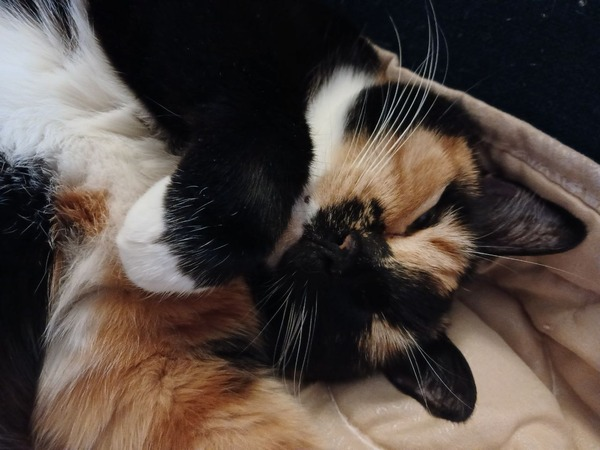

Предположу, что это кот Елены Олеговны!

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Домашнее задание было среднего уровня сложности. Были некоторые пробелы, которые необходимо было дополнительно отработать, прочитать какие-то материалы, учебники. Однозначно полезное дз, достаточно подробно разобрался в теме. Однако, очень долго разбирался во всем и в целом долго выполнял все дз((  Из интересного: запрос sql к БД в начале дз, а также раздел с калибровкой вероятностей и интерпретацией важности признаков при помощи SHAP и LIME.